# v3_nst_afxB.ipynb

A copy of `v3_nst_afx` where the parameter dictionaries that initialize the network come from `v3_nst_afx_hyper`, rather than some SMAC-based notebook (e.g. `v3_hyperparameters`).

`v3_nst_afx` is a copy of v3_normal_smac_test.ipynb, where the AF population does not have variable thresholds (chwr_linear units). Another variation to have logarithmic units in the SPF population.

In [1]:
%cd ../..
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
%load_ext Cython

In [3]:
%%cython
from draculab import *

In [4]:
# default configuration
def_cfg50 = {'b_e':4.00, 'M__C_lrate':20.26, 'sig1':0.49, 'SPF_w':1.50, 'M__C_w_sum':3.00, 'AL_thresh':0.30, 
           'g_e_factor':2.00, 'integ_amp':1.87, 'integ_decay':1.33, 'dely_diff':0.45, 'adapt_amp':5.00, 
           'C_tau_slow':49.90, 'SF_slope_factor':8.00, 'sig2':0.53, 'dely_low':0.77, 'n_evals':0.00 }
def_cfg26 = {'C_tau_slow':23.24, 'sig2':0.65, 'integ_decay':1.68, 'fitness':0.05, 'M__C_w_sum':3.03, 
             'n_evals':27.00, 'integ_amp':1.94, 'adapt_amp':5.00, 'dely_diff':0.61, 'SPF_w':1.50, 'M__C_lrate':24.82, 
             'sig1':0.07, 'g_e_factor':2.00, 'AL_thresh':0.38, 'dely_low':0.94, 'b_e':2.98, 'SF_slope_factor':8.00}
np.random.seed(123456)

In [5]:
# Load a saved population
import pickle
fname = 'v3_nst_afx_pop_2020-08-09__20_39_gen26'
with (open(fname, "rb")) as f:
    pop = pickle.load(f)
    f.close()

In [6]:
# select configuration
#cfg = def_cfg26
cfg = pop[0]

In [7]:
# print used configuration
for dic in pop[0:1]:
    print('{',end='')
    for name in dic.keys():
        if name != 'fitness' or dic['fitness'] != None:
            print("\'%s\':%.2f, " % (name, dic[name]), end='')
    print('}\n')

pop[0]

{'SPF_w':1.50, 'integ_decay':1.68, 'b_e':2.98, 'M__C_lrate':24.82, 'fitness':0.05, 'g_e_factor':2.00, 'adapt_amp':5.00, 'sig2':0.65, 'integ_amp':1.94, 'dely_low':0.94, 'M__C_w_sum':3.03, 'AL_thresh':0.38, 'sig1':0.07, 'SF_slope_factor':8.00, 'n_evals':27.00, 'dely_diff':0.61, 'C_tau_slow':23.24, }



{'AL_thresh': 0.37841631444193735,
 'C_tau_slow': 23.242490852056637,
 'M__C_lrate': 24.822,
 'M__C_w_sum': 3.0270993105330284,
 'SF_slope_factor': 8.0,
 'SPF_w': 1.5,
 'adapt_amp': 5.0,
 'b_e': 2.9821640778874707,
 'dely_diff': 0.606,
 'dely_low': 0.938,
 'fitness': 0.05097870244805127,
 'g_e_factor': 2.0,
 'integ_amp': 1.9404408352576688,
 'integ_decay': 1.676,
 'n_evals': 27,
 'sig1': 0.067,
 'sig2': 0.647}

In [8]:
##################################
####### Create the network #######
##################################

t_pres = 30. # number of seconds to hold each set of target lengths
rand_w = True # whether to use random weights in M->C, AF->M
rga_diff = True # if True use gated_normal_rga_diff, if False gated_normal_rga
rand_targets = True # whether to train using a large number of random targets
par_heter = 0.001 # range of heterogeneity as a fraction of the original value

net_params = {'min_delay' : 0.005,
          'min_buff_size' : 10 }

P_params = {  'type' : plant_models.bouncy_planar_arm_v3,
          'mass1': 1.,
          'mass2': 1.,
          's_min' : -0.8,
          'p1' : (-0.01, 0.04),
          'p2' : (0.29, 0.03),
          'p3' : (0., 0.05),
          'p5' : (0.01, -0.05),
          'p10': (0.29, 0.03),
          'init_q1': 0.,
          'init_q2': np.pi/2.,
          'init_q1p': 0.,
          'init_q2p': 0.,
          'g': 0.0,
          'mu1': 3.,
          'mu2': 3.,
          'l_torque' : 0.01,
          'l_visco' : 0.01,
          'g_e' : cfg['g_e_factor']*np.array([17., 20., 18., 17., 20., 22.]),
          'l0_e' : [1.]*6,
          'Ia_gain' : 2.5*np.array([3.,10.,10., 3.,10.,10.]),
          'II_gain' : 2.*np.array([3., 8., 8., 3., 8., 8.]),
          'Ib_gain' : 1.,
          'T_0' : 10.,
          'k_pe_e' : 20.,  #8
          'k_se_e' : 20., #13
          'b_e' : cfg['b_e'],
          'g_s' : 0.02,
          'k_pe_s' : 2., 
          'k_se_s' : 2.,
          'g_d' : 0.01,
          'k_pe_d' : .2, #.1,
          'k_se_d' : 1., #2.,
          'b_s' : .5,
          'b_d' : 2.,#3.,
          'l0_s': .7,
          'l0_d': .8,
          'fs' : 0.1,
          'se_II' : 0.5,
          'cd' : 0.5,
          'cs' : 0.5,
          'tau' : 0.1   # ficticious time constant used in create_freqs_steps
           }
net = network(net_params)
#P = net.create(1, P_params)
#arm = net.plants[P]

# We organize the spinal connections through 4 types of symmetric relations
# these lists are used to set intraspinal connections and test connection matrices
antagonists = [(0,3), (1,2), (4,5)]
part_antag = [(0,2),(0,5), (3,4), (1,3)]
synergists = [(0,1), (0,4), (2,3), (3,5)]
part_syne = [(1,4), (2,5)]
self_conn = [(x,x) for x in range(6)]

antagonists += [(p[1],p[0]) for p in antagonists]
part_antag += [(p[1],p[0]) for p in part_antag]
synergists += [(p[1],p[0]) for p in synergists]
part_syne += [(p[1],p[0]) for p in part_syne]
all_pairs = [(i,j) for i in range(6) for j in range(6)]
#unrelated = set(all_pairs) - set(antagonists) - set(part_antag) - set(synergists) - set(part_syne) - set(self_conn)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# UNIT PARAMETER DICTIONARIES
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
randz6 = lambda : (1. + par_heter*(np.random.rand(6)-0.5))
randz12 = lambda : (1. + par_heter*(np.random.rand(12)-0.5))
randz18 = lambda : (1. + par_heter*(np.random.rand(18)-0.5))
randz36 = lambda : (1. + par_heter*(np.random.rand(36)-0.5))

ACT_params = {'type' : unit_types.act,
              'tau_u' : 8.,
              'gamma' : 2.,
              'g' : 2.,
              'theta' : 1.,
              'tau_slow' : 5.,
              'y_min' : 0.2,
              'rst_thr' : 0.1,
              'init_val' : 0. }
spf_sum_min = .4 # value where no corrections are needed anymore
y_min = 1./(1. + np.exp(-ACT_params['g']*(spf_sum_min - ACT_params['theta'])))
ACT_params['y_min'] = y_min

AF_params = {'type' : unit_types.logarithmic,
             'init_val' : [0.1, 0.05, 0.15, 0.1, 0.1, 0.1, # avg afferent values
                           0.2, 0.15, 0.3, 0.3, 0.2, 0.25,
                           0.2, 0.4, 0.4, 0.2, 0.4, 0.4]*2,
                           #0.3, 0.4, 0.5, 0.3, 0.3, 0.5]*2,
             'tau' : 0.02 * randz36(),
             'tau_fast': 0.1,
             'tau_mid' : 1.,
             'tau_slow' : 40.,
             'delay' : 0.1,
             'thresh' : [0.05]*18 + [-0.4]*18 } 
AL_params = {'type' : unit_types.sigmoidal,
             'thresh' : cfg['AL_thresh'] * randz6(),
             'slope' : 2. * randz6(),
             'init_val' : 0.1 * randz6(),
             'tau' : 0.02 * randz6() }
CE_params = {'type' : unit_types.gated_rga_inpsel_adapt_sig,
             'thresh' : 0. * randz6(),
             'slope' : 1.5 * randz6(),
             'init_val' : 0.2 * randz6(),
             'tau' : 0.02,
             'tau_fast': 0.1,
             'tau_mid' : 1.,
             'tau_slow' : cfg['C_tau_slow'],
             'custom_inp_del' : 15, # placeholder values
             'custom_inp_del2': 30,
             'integ_amp' : cfg['integ_amp'],
             'integ_decay' : cfg['integ_decay'],
             'adapt_amp' : cfg['adapt_amp'],
             'delay' : 0.2,
             'des_out_w_abs_sum' : 1. }
CI_params = {'type' : unit_types.gated_rga_inpsel_adapt_sig,
             'thresh' : 0.5 * randz6(),
             'slope' : 2. * randz6(),
             'init_val' : 0.2 * randz6(),
             'tau' : 0.1,
             'tau_fast': 0.1,
             'tau_mid' : 1.,
             'tau_slow' : cfg['C_tau_slow'],
             'custom_inp_del' : 15, # placeholder values
             'custom_inp_del2': 30,
             'integ_amp' : cfg['integ_amp'], #.5,
             'integ_decay' : cfg['integ_decay'],
             'adapt_amp' : cfg['adapt_amp'],
             'delay' : 0.2,
             'des_out_w_abs_sum' : 1. }
M_params = {'type' : unit_types.gated_out_norm_am_sig,
            'thresh' : 0. * randz12(),
            'slope' : 3. * randz12(),
            'init_val' : 0.2 * randz12(),
            'delay' : 0.2,
            'tau_fast': 0.15,
            'tau_mid': 1.5,
            'tau_slow' : 10.,
            'tau' : 0.01 * randz12(),
            'p0_inp' : 0.0,
            'des_out_w_abs_sum' : 2. }
SF_params = {'type' : unit_types.sigmoidal,
             #'thresh' : np.array([-0.02]*12)
             'thresh' : np.array([-0.02, -0.01, 0.03, -0.01, -0.03, -0.02, -0.02, -0.01, 0.03, -0.01, -0.03, -0.02]),
             #'slope' : np.array([np.log(5.)]*12), #np.array([np.log(9.)]*12),
             'slope' : cfg['SF_slope_factor']*np.array([1.37]*12),
             'init_val' : 0.2 * randz12(),
             'tau' : 0.03 * randz12() } 
SP_params = {'type' : unit_types.source,
             'init_val' : 0.5,
             'tau_fast' : 0.02,
             'tau_mid' : 0.1,
             'function' : lambda t: None }
SP_CHG_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.25,
              'slope' : 9.,
              'init_val' : 0.1,
              'tau' : 0.01 }
SPF_params = {'type' : unit_types.logarithmic, #sigmoidal,
              'thresh' : -0.1, #0.4 * randz12(),
              'slope' : 6. * randz12(),
              'init_val' : 0.3 * randz12(),
              'tau_fast': 0.005,
              'tau_mid': 0.05,
              'tau_slow' : 5.,
              'tau' : 0.02 * randz12() }
track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CONNECTION DICTIONARIES
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# ACT to CE,CI ------------------------------------------------
ACT__CE_conn = {'rule' : "all_to_all",
                'delay' : 0.02 } 
ACT__CE_syn = {'type' : synapse_types.static,
               'inp_ports' : 4,
               'init_w' : 1. }
ACT__CI_conn = {'rule' : "all_to_all",
                'delay' : 0.02 } 
ACT__CI_syn = {'type' : synapse_types.static,
               'inp_ports' : 4,
               'init_w' : 1. }
# AF to CE, CI --------------------------------------------------
AF__CE_conn = {'rule' : 'all_to_all',
               'delay' : 0.02 }
AF__CE_syn = {'type' : synapse_types.gated_inp_sel,
              'aff_port' : 2,
              'inp_ports' : 2,
              'error_port' : 0,
              'normalize' : True,
              'w_sum' : 2.,
              'lrate' : 0., #10.,
              'extra_steps' : 1,
              'init_w' : 0.005 }
AF__CI_conn = {'rule' : 'all_to_all',
               'delay' : 0.02 }
AF__CI_syn = {'type' : synapse_types.gated_inp_sel,
              'aff_port' : 2,
              'inp_ports' : 2,
              'error_port' : 0,
              'normalize' : True,
              'w_sum' : 2.,
              'lrate' : 0., #10.,
              'extra_steps' : 1,
              'init_w' : 0.005 }
# AF to M ------------------------------------------------
## Creating a test matrix
if not rand_w:
    # Initializing manually
    AF_M = np.zeros((36, 12)) # rows are source, columns target
    for src in range(36):
        for trg in range(12):
            src_pop = src%6 #src's population
            trg_pop = trg%6 #trg's population
            if src%18 < 6: # if the afferent is tension, don't reverse signs
                sig = 1
            else:
                sig = -1
            if src > 17: sig = -sig # if 'negative' afferent reverse sign
            for pair in antagonists:
                if pair == (src_pop, trg_pop):
                    AF_M[src, trg] = sig*0.2
                    break
            else: 
                for pair in part_antag:
                    if pair == (src_pop, trg_pop):
                        AF_M[src, trg] = sig*0.1
                        break
                else: 
                    for pair in synergists:
                        if pair == (src_pop, trg_pop):
                            AF_M[src, trg] = sig*-0.2
                            break
                    else: 
                        for pair in synergists:
                            if pair == (src_pop, trg_pop):
                                AF_M[src, trg] = sig*-0.2
                                break
                        else: 
                            for pair in part_syne:
                                if pair == (src_pop, trg_pop):
                                    AF_M[src, trg] = sig*-0.1
                                    break
                            else:
                                if src_pop == trg_pop:
                                    AF_M[src, trg] = sig*-0.3
else:
    #AF_M = 0.2*(np.random.random((12,12)) - 0.5) # random initial connections!!!!!
    AF_M = 0.2*(np.random.random((12,36)) - 0.5) # random initial connections!!!!!
AF__M_conn = {'rule' : 'all_to_all',
             'delay' : 0.02 }
AF__M_syn = {'type' : synapse_types.gated_diff_inp_sel,
            'aff_port' : 0,
            'error_port' : 1,
            'normalize' : True,
            'w_sum' : 10.,
            'inp_ports' : 0, # afferent for out_norm_am_sig
            'input_type' : 'pred', # if using inp_corr
            'lrate' : 15., #10.
            'extra_steps' : None, # placeholder value; filled below,
            'init_w' : AF_M.flatten() }
# AF to SF ------------------------------------------------
AF__SF_dubya = np.array([0.57, 0.56, 0.56, 0.57, 0.55, 0.55, 0.57, 0.56, 0.56, 0.57, 0.55, 0.55])
AFe__SF_conn = {'rule' : 'one_to_one',
              'delay' : 0.02 }
AFe__SF_syn = {'type' : synapse_types.static,
             #'init_w' : .5*np.array([ 39.73, 15.03,  9.66, 116.47, 8.63,  63.68, 20.88, 9.69, 5.86, 67.98, 5.44, 57.38]) }
               #'init_w' : np.array([15.07516819, 20.60577773,  6.32821777, 14.08991768,  5.69679834,  8.89424814,
               #                     7.68013805, 13.46076843,  3.87962611,  7.1693345,   3.5817668,   5.8075114 ])}
               'init_w' : AF__SF_dubya}
AFi__SF_conn = {'rule' : 'one_to_one',
              'delay' : 0.02 }
AFi__SF_syn = {'type' : synapse_types.static,
             #'init_w' : .5*np.array([-162.42, -9.56, -15.19, -50.0, -88.47, -9.73, -67.67, -5.85, -9.96, -23.55, -50.63, -5.81])}
              #'init_w' : np.array([-15.36496074,  -5.96985989, -21.78133701, -18.88200345, -11.38248201,
              #            -6.93261446,  -7.53984025,  -3.68499008, -14.59079011,  -9.22649886,  -7.03063956,  -4.19297924])}
              'init_w' : -AF__SF_dubya }
# AL to P ------------------------------------------------
AL__P_conn = {'inp_ports' : list(range(6)),
             'delays': 0.01 }
AL__P_syn = {'type': synapse_types.static,
            'init_w' : 1. }
# CE, CI to AL ----------------------------------------------
CE__AL_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CE__AL_syn = {'type' : synapse_types.static,
              'init_w' : [1., 1., 1., 1., 1., 1.] }
CI__AL_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CI__AL_syn = {'type' : synapse_types.static,
              'init_w' : -1. }
# CE,CI to CE,CI  ------------------------------------------------
CE__CI_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CI__CE_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CE__CI_syn = {'type' : synapse_types.static,
              'inp_ports' : 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
              'init_w' : 1. }
CI__CE_syn = {'type' : synapse_types.static, #static, #corr_inh,
              'inp_ports' : 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
              'lrate' : .0,
              'des_act' : 0.5,
              'init_w' : -2. }
C__C_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.015 }
C__C_syn_antag = {'type' : synapse_types.static, #bcm,
                  'inp_ports': 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
                  'init_w' : 2., #16.,
                  'lrate' : 1.,
                  'des_act' : .5 }
C__C_syn_p_antag = {'type' : synapse_types.static, #bcm,
                  'inp_ports': 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
                  'init_w' : .5, # 8.,
                  'lrate' : 1.,
                  'des_act' : 0.2 }
C__C_syn_syne = {'type' : synapse_types.static,
                 'inp_ports': 1,
                 'lrate' : 1.,
                 'init_w' : .5 }
C__C_syn_p_syne = {'type' : synapse_types.static,
                   'inp_ports': 1,
                   'lrate' : 1.,
                   'init_w' : 0.2 }
C__C_syn_null_lat = {'type' : synapse_types.static, # connection with static weight zero
                   'inp_ports': 1,
                   'lrate' : 1.,
                   'init_w' : 0. }
C__C_syn_null_aff = {'type' : synapse_types.static, # connection with static weight zero
                   'inp_ports': 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
                   'lrate' : 1.,
                   'init_w' : 0. }

# M to CE,CI ----------------------------------------------
# creating a test matrix
if not rand_w:
    # initializing manually
    M_CE = np.array(
        [[ 0.2,  0.1, -0.1, -0.2,  0.1, -0.1],
         [ 0.1,  0.2, -0.2, -0.1,  0.1,  0.0],
         [-0.1, -0.2,  0.2,  0.1,  0.0,  0.0],
         [-0.2, -0.1,  0.1, -0.2, -0.1,  0.1],
         [ 0.1,  0.0,  0.0, -0.1,  0.3, -0.2],
         [-0.1,  0.0,  0.0,  0.1, -0.2,  0.3],
         [ 0.2,  0.1, -0.1, -0.2,  0.1, -0.1],
         [ 0.1,  0.2, -0.2, -0.1,  0.1,  0.0],
         [-0.1, -0.2,  0.2,  0.1,  0.0,  0.0],
         [-0.2, -0.1,  0.1, -0.2, -0.1,  0.1],
         [ 0.1,  0.0,  0.0, -0.1,  0.3, -0.2],
         [-0.1,  0.0,  0.0,  0.1, -0.2,  0.3]])
    M_CI = -M_CE 
else:
    M_CE = 0.4*(np.random.random((12,6)) - 0.5) # random initial connections!!!!!
    M_CI = 0.4*(np.random.random((12,6)) - 0.5) # random initial connections!!!!!
if rga_diff:
    M__C_type = synapse_types.gated_normal_rga_diff
else:
    M__C_type = synapse_types.gated_normal_rga
M__CE_conn = {'rule': 'all_to_all',
             'delay': 0.02 }
M__CE_syn = {'type' : M__C_type,
             'inp_ports' : 0,
             'lrate' : 20.,
             'w_sum' : cfg['M__C_w_sum'],
             'sig1' : cfg['sig1'],
             'sig2' : cfg['sig2'],
             'w_thresh' : 0.05,
             'w_decay': 0.005,
             'w_tau' : 60.,
             'init_w' : M_CE.flatten() }
M__CI_conn = {'rule': 'all_to_all',
             'delay': 0.02 }
M__CI_syn = {'type' : M__C_type,
             'inp_ports' : 0,
             'lrate' : 20.,
             'w_sum' : cfg['M__C_w_sum'],
             'sig1' : cfg['sig1'],
             'sig2' : cfg['sig2'],
             'w_thresh' : 0.05,
             'w_tau' : 60.,
             'w_decay': 0.005,
             'init_w' : M_CI.flatten() }
# P to AF  ---------------------------------------------------
idx_aff = np.arange(22,40) # indexes for afferent output in the arm
P__AF_conn = {'port_map' : [[(p,0)] for p in idx_aff],
             'delays' : 0.02 }
Pe__AF_syn = {'type' : synapse_types.static,
              'init_w' : [1.]*18 } 
Pi__AF_syn = {'type' : synapse_types.static,
            'init_w' :  [-1.]*18 }
# SF, SP to SPF ------------------------------------------------
SFe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SFi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SFe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : cfg['SPF_w'] }
SFi__SPF_syn = {'type' : synapse_types.static,
                'init_w' : -cfg['SPF_w'] }
SPe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SPi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SPe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : cfg['SPF_w'] }
SPi__SPF_syn = {'type' : synapse_types.static,
               'init_w' : -cfg['SPF_w'] }
# SP to SP_CHG ------------------------------------------------
SP__SP_CHG_conn = {'rule' : 'all_to_all',
                    'delay' : 0.01}
SP__SP_CHG_syn = {'type' : synapse_types.chg,
                  'init_w' : 0.,
                  'lrate' : 20. }
# SP_CHG to CE, CI ------------------------------------------------
SP_CHG__CE_conn = {'rule' : "all_to_all",
                  'delay' : 0.02 }
SP_CHG__CE_syn = {'type' : synapse_types.static,
                  'inp_ports' : 3,
                  'init_w' : 1. }
SP_CHG__CI_conn = {'rule' : "all_to_all",
                   'delay' : 0.02 }
SP_CHG__CI_syn = {'type' : synapse_types.static,
                  'inp_ports' : 3,
                  'init_w' : 1. }
# SP_CHG to ACT ------------------------------------------------
SP_CHG__ACT_conn = {'rule' : "all_to_all",
                   'delay' : 0.02 }
SP_CHG__ACT_syn = {'type' : synapse_types.static,
                  'inp_ports' : 1,
                  'init_w' : 1. }
# SP_CHG to M ------------------------------------------------
SP_CHG__M_conn = {'rule' : "all_to_all",
                  'delay' : 0.02 }
SP_CHG__M_syn = {'type' : synapse_types.static,
                  'inp_ports' : 2,
                  'init_w' : 1. }
# SPF to ACT ------------------------------------------------
SPF__ACT_conn = {'rule' : "all_to_all",
                 'delay' : 0.02 }
SPF__ACT_syn = {'type' : synapse_types.static,
                'inp_ports' : 0,
                'init_w' : 1. }
# SPF to M  ------------------------------------------------
SPF__M_conn = {'rule': 'one_to_one',
               'delay': 0.01 }
SPF__M_syn = {'type' : synapse_types.static, #synapse_types.inp_corr,
              'inp_ports' : 1,
              'lrate' : 0.,
              'input_type' : 'error', # if using inp_corr
              'init_w' : 1. }

#*************************************************************
# PROSPECTIVE CHANGES TO DEFAULTS
# to reduce the trajectory asymmetry
C__C_syn_antag['init_w'] = 1.2 
C__C_syn_p_antag['init_w'] = .2
# to balance the muscles
P_params['g_e'] = 2.1*np.array([18., 20., 20., 18., 24., 26.])
# to stop circular reaching in high-gain sitauations
CE__CI_syn['init_w'] = 0.9
CI__CE_syn['init_w'] = -1.5

#*************************************************************
# Setting the right delay for AF-->M
f = 1. # going to estimate the extra delay of error inputs wrt afferent inputs at M
w = 2.*np.pi*f
sf_del = np.arctan(np.mean(SF_params['tau'])*w)/w
spf_del = np.arctan(np.mean(SPF_params['tau'])*w)/w
delay = spf_del + sf_del + AFe__SF_conn['delay'] + SFe__SPF_conn['delay']
steps = int(round(delay/net.min_delay))
AF_params['delay'] = AF_params['delay'] + (
                     net_params['min_delay'] * (np.ceil(delay/net_params['min_delay']) + 1))
AF__M_syn['extra_steps'] = steps
#*************************************************************
# utilitiy function for the M-->C delays used in the rga rule
def approx_del(f):
    """ Returns an estimate fo the optimal delay for rga learning.

        We assume that the important loop for the learning rule in the C units
        is the one going through C-AL-P-AF-M-C.
        We also assume the delays to/from CI are the same as the ones for CE.

        Args:
            f : oscillation frequency of E-I pair in C, in Hertz
        Returns:
            2-tuple : (time_del, del_steps)
            time_del : A float with the time delay.
            del_steps : time delay as integer number of min_del steps.
    """
    w = 2.*np.pi*f
    al_del = np.arctan(np.mean(AL_params['tau'])*w)/w
    p_del = np.arctan(np.mean(P_params['tau'])*w)/w
    af_del = np.arctan(np.mean(AF_params['tau'])*w)/w
    m_del = np.arctan(np.mean(M_params['tau'])*w)/w
    D = [CE__AL_conn['delay'], AL__P_conn['delays'], np.mean(P__AF_conn['delays']),
         AF__M_conn['delay'], M__CE_conn['delay'] ]
    time_del = al_del + p_del + af_del + m_del + sum(D)
    del_steps = int(np.ceil(time_del/net_params['min_delay']))
    time_del = del_steps*net_params['min_delay']
    del_steps -= 1 # because this is an index, and indexes start at 0
    return time_del, del_steps
############## Approximating the delays for the rga rule #############
######## Using the utility function (for rga synapses)
# time_del, del_steps = approx_del(0.01) #0.65 was approximate CE/CI frequency observed in simulations
# #time_del, del_steps = (1., 200-1)
# CE_params['delay'] = time_del
# CI_params['delay'] = time_del
# M_params['delay'] = time_del
# CE_params['custom_inp_del'] = del_steps
# CI_params['custom_inp_del'] = del_steps
######## Using the two custom delays (for rga_diff synapses)
dely1 = round(cfg['dely_low']/net.min_delay)*net.min_delay
dely2 = dely1 + round(cfg['dely_diff']/net.min_delay)*net.min_delay
del_steps1 = int(np.ceil(dely1/net_params['min_delay'])) - 1
del_steps2 = int(np.ceil(dely2/net_params['min_delay'])) - 1
CE_params['delay'] = dely2 + 0.01
CI_params['delay'] = dely2 + 0.01
M_params['delay'] = dely2 + 0.01
CE_params['custom_inp_del'] = del_steps1
CI_params['custom_inp_del'] = del_steps1
CE_params['custom_inp_del2'] = del_steps2
CI_params['custom_inp_del2'] = del_steps2
#*************************************************************

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CREATING UNITS
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

P = net.create(1, P_params)
arm = net.plants[P]

ACT = net.create(1, ACT_params)
AF = net.create(36, AF_params)
AL = net.create(6, AL_params)
CE = net.create(6, CE_params)
CI = net.create(6, CI_params)
M = net.create(12, M_params)
SF = net.create(12, SF_params)
SP = net.create(12, SP_params)
SP_CHG = net.create(1, SP_CHG_params)
SPF = net.create(12, SPF_params)

# SET THE PATTERNS IN SP -----------------------------------------------------
# list with hand coordinates [x,y] (meters)
if rand_targets is False:
    hand_coords = [[0.3, 0.45], 
                   [0.35, 0.4],
                   [0.4, 0.35],
                   [0.35, 0.3],
                   [0.3, 0.25],
                   [0.25, 0.3],
                   [0.2, 0.35],
                   [0.25, 0.4]]
                   #[-0.1, 0.3],
                   #[-0.1, 0.35]] # experimental extra coordinates
else:
    # creating a list of random coordinates to use as targets
    min_s_ang = -0.1 # minimum shoulder angle
    max_s_ang = 0.8  # maximum shoulder angle
    min_e_ang = 0.2 # minimum elbow angle
    max_e_ang = 2.3 # maximum elbow angle
    n_coords = 1000 # number of coordinates to generate
    l_arm = net.plants[P].l_arm # upper arm length
    l_farm = net.plants[P].l_farm # forearm length
    hand_coords = [[0.,0.] for _ in range(n_coords)]
    s_angs = (np.random.random(n_coords)+min_s_ang)*(max_s_ang-min_s_ang)
    e_angs = (np.random.random(n_coords)+min_e_ang)*(max_e_ang-min_e_ang)
    for i in range(n_coords):
        hand_coords[i][0] = l_arm*np.cos(s_angs[i]) + l_farm*np.cos(s_angs[i]+e_angs[i]) # x-coordinate
        hand_coords[i][1] = l_arm*np.sin(s_angs[i]) + l_farm*np.sin(s_angs[i]+e_angs[i]) # y-coordinate

# list with muscle lengths corresponding to the hand coordinates
m_lengths = []
for coord in hand_coords:
    m_lengths.append(arm.coords_to_lengths(coord))
m_lengths = np.array(m_lengths)
#(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
# We need to translate these lengths to corresponding SF activity levels.
# For that it is necessary to recreate all their transformations
# The first transformation is from length to Ia, II afferent activity.
### OUT OF THE 36 AFFERENT SIGNALS, WE TAKE THE Ia AND II ###
par = net.plants[P].m_params
# steady state tensions in the static and dynamic bag fibers (no gamma inputs)
Ts_ss = (par['k_se_s']/(par['k_se_s']+par['k_pe_s'])) * (
         par['k_pe_s']*(m_lengths - par['l0_s']))
Td_ss = (par['k_se_d']/(par['k_se_d']+par['k_pe_d'])) * (
         par['k_pe_d']*(m_lengths - par['l0_d']))
# steady state afferent outputs (no gamma inputs)
Ia_ss = par['fs']*(Ts_ss/par['k_se_s']) + (1.-par['fs'])*(Td_ss/par['k_se_d'])
II_ss = par['se_II']*(Ts_ss/par['k_se_s']) + ((1.-par['se_II'])/par['k_pe_s'])*Ts_ss
Ia_ss *= par['Ia_gain']
II_ss *= par['II_gain']
Ia_II_ss = np.concatenate((Ia_ss, II_ss), axis=1)
# Next transformation is through the afferent units
Pe__AF_ws = np.array(Pe__AF_syn['init_w'][6:18])
Pi__AF_ws = np.array(Pi__AF_syn['init_w'][6:18])
#Ia_II_avgs = np.mean(Ia_II_ss, axis=0)  # when using hundreds of random targets
# target averages
AFe_thr = np.array([net.units[u].thresh for u in AF[6:18]])
AFi_thr = np.array([net.units[u].thresh for u in AF[24:36]])
#AF_Ia = np.maximum((Ia_ss - AF_avgs[0:6])*Pe__AF_Ia_ws - AF_thr[0:6], 0.)
#AF_II = np.maximum((II_ss - AF_avgs[6:12])*Pe__AF_II_ws - AF_thr[6:12], 0.)
AFe_Ia_II = np.log(1. + np.maximum((Ia_II_ss)*Pe__AF_ws - AFe_thr, 0.))
AFi_Ia_II = np.log(1. + np.maximum((Ia_II_ss)*Pi__AF_ws - AFi_thr, 0.))
#(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
# Next is from AF to SF
SF_arg = AFe__SF_syn['init_w']*AFe_Ia_II + AFi__SF_syn['init_w']*AFi_Ia_II
SF_out = 1./ (1. + np.exp(-SF_params['slope']*(SF_arg - SF_params['thresh'])))
SF_params['init_val'] = SF_out # this might cause a smooth start
# now we set the values in SP
m_idxs = np.random.randint(len(hand_coords), size=1000) # index of all targets
    #m_idxs[0] = 0 # for testing
AF_us = [net.units[u] for u in AF]

def SF_sigmo(idx, arg):
    """ The sigmoidal function for SF unit with index SF[idx]. """
    return 1./ (1. + np.exp(-SF_params['slope'][idx]*(arg - SF_params['thresh'][idx])))

def cur_target(t):
    """ Returns the index of the target at time t. """
    return m_idxs[int(np.floor(t/t_pres))]

def make_fun(idx):
    """ create a function for the SP unit with index 'idx'. """
    return lambda t: SF_sigmo(idx, 
                        AFe__SF_syn['init_w'][idx] * (
                        np.log(1. + max(Ia_II_ss[cur_target(t)][idx] * Pe__AF_ws[idx] - 
                        net.units[AF[6+idx]].thresh, 0.))) +
                        AFi__SF_syn['init_w'][idx] * (
                        np.log(1. + max(Ia_II_ss[cur_target(t)][idx] * Pi__AF_ws[idx] - 
                        net.units[AF[24+idx]].thresh, 0.))))
    #return lambda t: SF_out[m_idxs[int(np.floor(t/t_pres))]][idx]

for idx, u in enumerate(SP):
    net.units[u].set_function(make_fun(idx))

# tracking units
M_CE_track = net.create(len(M), track_params) # to track weights from M to CE
#M_CI_track = net.create(len(M), track_params) # to track weights from M to CI
AF_M0_track = net.create(18, track_params) # to track the weights from AF to M0

# xp_track = net.create(1, track_params) # del_avg_inp_deriv of C0 at port 1
# up_track = net.create(1, track_params) # to track the derivative of CE0
# if rga_diff is True:
#     sp_now_track = net.create(1, track_params)
#     sp_del_track = net.create(1, track_params)
#     spj_now_track = net.create(1, track_params)
#     spj_del_track = net.create(1, track_params)
# else:
#     sp_track = net.create(1, track_params) # avg_inp_deriv_mp for CE0 at port 0
#     spj_track = net.create(1, track_params) # input derivative for MX--CE0

ipx_track = net.create(12, track_params) # x coordinates of insertion points
ipy_track = net.create(12, track_params) # y coordinates of insertion points

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CONNECTING
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# from M to CE
net.connect(M, CE, M__CE_conn, M__CE_syn)
# from M to CI
net.connect(M, CI, M__CI_conn, M__CI_syn)
# from CE to AL
net.connect(CE, AL, CE__AL_conn, CE__AL_syn)
# from CI to AL
net.connect(CI, AL, CI__AL_conn, CI__AL_syn)
# from AL to P
net.set_plant_inputs(AL, P, AL__P_conn, AL__P_syn)
# from P to AF
net.set_plant_outputs(P, AF[0:18], P__AF_conn, Pe__AF_syn)
net.set_plant_outputs(P, AF[18:36], P__AF_conn, Pi__AF_syn)
# from AF to SF. Only Ia and II are selected
net.connect(AF[6:18], SF, AFe__SF_conn, AFe__SF_syn)
net.connect(AF[24:36], SF, AFi__SF_conn, AFi__SF_syn)
# from AF to M
## When connecting from all afferents:
net.connect(AF, M, AF__M_conn, AF__M_syn) # should be made before SPF-->M
## When connecting only from tension afferents
#net.connect(AF[0:6]+AF[18:24], M, AF__M_conn, AF__M_syn) # should be made before SPF-->M
# from AF to CE,CI
#net.connect(AF, CE, AF__CE_conn, AF__CE_syn)
#net.connect(AF, CI, AF__CI_conn, AF__CI_syn)
# from SF, SP to SPF
net.connect(SF, SPF, SFe__SPF_conn, SFe__SPF_syn) # F-P
#net.connect(SF, SPF, SFi__SPF_conn, SFi__SPF_syn)  # P-F
net.connect(SP, SPF, SPi__SPF_conn, SPi__SPF_syn) # F-P
#net.connect(SP, SPF, SPe__SPF_conn, SPe__SPF_syn)  # P-F
# from SPF to M
net.connect(SPF, M, SPF__M_conn, SPF__M_syn) # should be after AF-->M
# from SPF to ACT
net.connect(SPF, ACT, SPF__ACT_conn, SPF__ACT_syn)
# from SP to SP_CHG
net.connect(SP, SP_CHG, SP__SP_CHG_conn, SP__SP_CHG_syn)
# from SP_CHG to CE,CI
net.connect(SP_CHG, CE, SP_CHG__CE_conn, SP_CHG__CE_syn)
net.connect(SP_CHG, CI, SP_CHG__CI_conn, SP_CHG__CI_syn)
# from SP_CHG to M
net.connect(SP_CHG, M, SP_CHG__M_conn, SP_CHG__M_syn)
# from SP_CHG to ACT
net.connect(SP_CHG, ACT, SP_CHG__ACT_conn, SP_CHG__ACT_syn)
# from ACT to CE, CI
net.connect(ACT, CE, ACT__CE_conn, ACT__CE_syn)
net.connect(ACT, CI, ACT__CI_conn, ACT__CI_syn)
# intraspinal connections 
# from CE to CI, and CI to CE
#net.connect(CE, CI, CE__CI_conn, CE__CI_syn)
#net.connect(CI, CE, CI__CE_conn, CI__CE_syn)
# agonists and antagonists
for pair in all_pairs:
    if pair in synergists:
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_syne)
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in part_syne:
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_p_syne)
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in antagonists:
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_antag)
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in part_antag:
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_p_antag)
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in self_conn:
        net.connect([CE[pair[0]]], [CI[pair[1]]], CE__CI_conn, CE__CI_syn)
        net.connect([CI[pair[0]]], [CE[pair[1]]], CI__CE_conn, CI__CE_syn)
    else:
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)

# SETTING UP WEIGHT TRACKING -- depends on the order of statements above!!!!!!
# This assumes the first connections to C are M-->C
def M_CE0_fun(idx):
    """ Creates a function to track a weight from M to CE0. """
    return lambda t: net.syns[CE[0]][idx].w
for idx in range(len(M)):
    net.units[M_CE_track[idx]].set_function(M_CE0_fun(idx))
# This assumes the first connections to M are AF-->M    
def AF_M0_fun(idx):
    """ Creates a function to track a weight from AF to M0. """
    return lambda t: net.syns[M[0]][idx].w
for idx, uid in enumerate(AF_M0_track):
    net.units[uid].set_function(AF_M0_fun(idx))

# SETTING TRACKING OF PLASTICITY FACTORS FOR MX-->CE0
# X = 0 # index of the M unit we'll monitor
# if rga_diff:
#     CE0 = net.units[CE[0]]
#     net.units[xp_track[0]].set_function(lambda t: CE0.double_del_avg_inp_deriv_mp[1][1])
#     po_de = CE0.custom_inp_del2
#     pre_de = CE0.custom_inp_del2 - CE0.custom_inp_del
#     net.units[up_track[0]].set_function(lambda t: CE0.get_lpf_fast(po_de) - CE0.get_lpf_mid(po_de))
#     net.units[sp_now_track[0]].set_function(lambda t: CE0.avg_inp_deriv_mp[0])
#     net.units[sp_del_track[0]].set_function(lambda t: CE0.double_del_avg_inp_deriv_mp[0][0])
#     ds = net.syns[CE[0]][X].delay_steps
#     net.units[spj_now_track[0]].set_function(lambda t: net.units[M[X]].get_lpf_fast(ds) - 
#                                                        net.units[M[X]].get_lpf_mid(ds))
#     net.units[spj_del_track[0]].set_function(lambda t: CE0.double_del_inp_deriv_mp[0][0][net.syns[CE[0]][X].ddidm_idx])
# else:
#     net.units[xp_track[0]].set_function(lambda t: net.units[CE[0]].del_avg_inp_deriv_mp[1])
#     po_de = net.units[CE[0]].custom_inp_del
#     net.units[up_track[0]].set_function(lambda t: net.units[CE[0]].get_lpf_fast(po_de) - 
#                                         net.units[CE[0]].get_lpf_mid(po_de))
#     net.units[sp_track[0]].set_function(lambda t: net.units[CE[0]].avg_inp_deriv_mp[0])
#     ds = net.syns[CE[0]][0].delay_steps
#     net.units[spj_track[0]].set_function(lambda t: net.units[M[X]].get_lpf_fast(ds) - 
#                                          net.units[M[X]].get_lpf_mid(ds))

# TRACKING OF INSERTION POINTS (for the arm animation)
# make the source units track the tensions
def create_xtracker(arm_id, idx):
    return lambda t: net.plants[arm_id].ip[idx][0]
def create_ytracker(arm_id, idx):
    return lambda t: net.plants[arm_id].ip[idx][1]
for idx, uid in enumerate(ipx_track):
    net.units[uid].set_function(create_xtracker(P, idx))
for idx, uid in enumerate(ipy_track):
    net.units[uid].set_function(create_ytracker(P, idx))

In [15]:
start_time = time.time()
times, data, plant_data  = net.flat_run(320.)
#times, data, plant_data  = net.run(40.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)
#Execution time is 8.687349319458008 seconds  << before sc_inp_sum_mp, flat_run(5.)

Execution time is 1328.6220695972443 seconds


In [ ]:
# run with variable lrate
n_reps = 6
t_rep = 150
MCbase_rate = 10.
MCdecay_rate = 0.7
MCdev_rate = 20.
AFMbase_rate = 5.
AFMdecay_rate = 0.7
AFMdev_rate = 20.
for rep in range(n_reps):
    # set learning rates
    M__C_lrate = MCbase_rate + MCdev_rate * np.exp(-MCdecay_rate*rep)
    AF__M_lrate = AFMbase_rate + AFMdev_rate * np.exp(-AFMdecay_rate*rep)
    
    for syn_list in net.syns:
        for syn in syn_list:
            if syn.preID in M and syn.postID in (CE+CI):
                syn.lrate = M__C_lrate
                syn.alpha = syn.lrate * net.min_delay
            elif syn.preID in AF and syn.postID in M:
                syn.lrate = AF__M_lrate
                syn.alpha = syn.lrate * net.min_delay

    # simulate
    start_time = time.time()
    times, data, plant_data  = net.flat_run(t_rep)

    print('Execution time on rep %d is %s seconds' % (rep, time.time() - start_time))

data = np.array(data)

Same history as `v3_nst_afx`

---
**Using logarithmic units in SF **
---
* With: 
SF_params['slope'] = 8.*np.array([1.35, 1.38, 1.43, 1.37, 1.35, 1.36, 1.35, 1.38, 1.43, 1.37, 1.35, 1.36])
CE_params['tau'] = 0.02
CI_params['tau'] = 0.1
ACT_params['y_min'] = 0.2
ACT_params['tau_u'] = 7.
P_params['k_pe_e'] = 25.
P_params['k_se_e'] = 20.
P_params['g_e'] = 2.*np.array([17., 20., 18., 17., 20., 20.])
CI__CE_syn['init_w'] = -2.
SPFw = 1.3
SPe__SPF_syn['init_w'] = SPFw
SPi__SPF_syn['init_w'] = -SPFw
SFe__SPF_syn['init_w'] = SPFw
SFi__SPF_syn['init_w'] = -SPFw
AL_params['thresh'] = 0.3
AL_params['tau'] = 0.02
CE_params['integ_amp'] = 0.
CI_params['integ_amp'] = 0.
CE_params['adapt_amp'] = 5.
CI_params['adapt_amp'] = 5.  
Reaching is done with oscillations. Mean error of ~0.1 after removing adaptation. Elbow seems uncapable of reaching small angles.
* Adding a bit more strength to the elbow extensor, and more damping to the muscles:
P_params['b_e'] = 8., 
P_params['g_e'] = 2.*np.array([17., 20., 18., 17., 20., 22.]).  
Reaching seems to be lazier.
* Removing some damping from the muscles:
P_params['b_e'] = 4.  
Reaching got pretty lazy. Mean error of ~0.2 in the first 1000 seconds.
* Adding more damping to the muscles
P_params['b_e'] = 8.  
Reching looks OK, but the elbow seems too lazy. Converging took ~600 seconds, but after that the average error was around 0.11.
* Adding monster elbow rotators:
P_params['g_e'] = 2.*np.array([17., 20., 18., 17., 30., 32.]).  
Seems to have gotten worse. 
* Using a waker arm, and also 20/20 muscle tensions: 
P_params['g_e'] = 1.5*np.array([17., 20., 18., 17., 20., 22.]).,
P_params['k_pe_e'] = 20.,
P_params['k_se_e'] = 20. ...
---
* to reduce the trajectory asymmetry  
C__C_syn_antag['init_w'] = 1.5   
C__C_syn_p_antag['init_w'] = .2  
to balance the muscles  
P_params['g_e'] = 2.5*np.array([17., 20., 20., 17., 24., 26.])  
to stop circular reaching in high-gain sitauations  
CE__CI_syn['init_w'] = .7 ...  
not very good

[1.14738215e-001 8.24349270e-002 1.06196001e-001 6.21282394e-002
 1.30110776e-001 9.38724727e-323 1.71120732e-001 1.47499329e-002
 1.72921393e-001 7.41331914e-003 3.30960451e-001 9.38724727e-323]
[4.06520844e-002 5.97880357e-002 7.41842830e-002 1.52692688e-002
 7.07290146e-002 1.08694442e-322 5.85589809e-002 1.90005364e-003
 1.13684271e-001 5.13956462e-003 1.54443747e-001 1.33397724e-322]


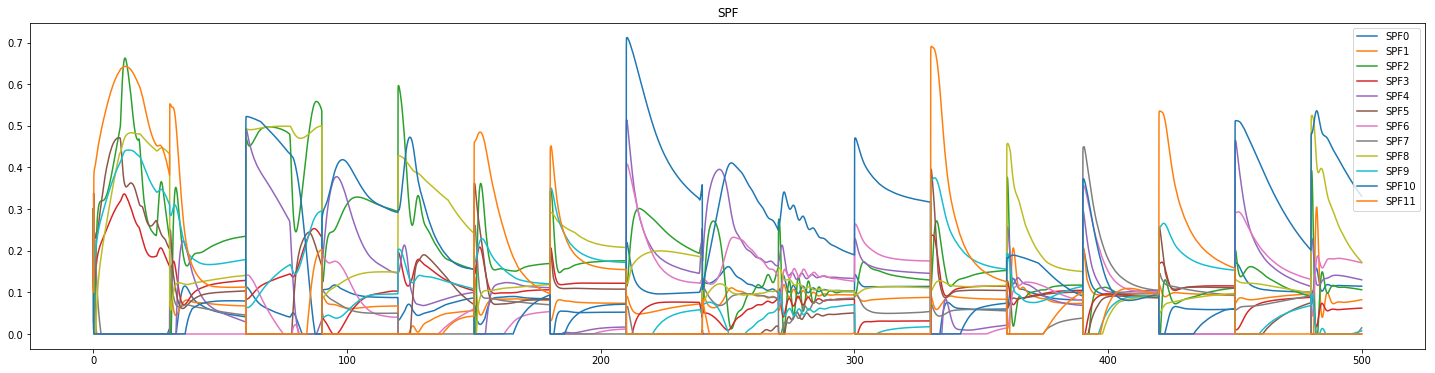

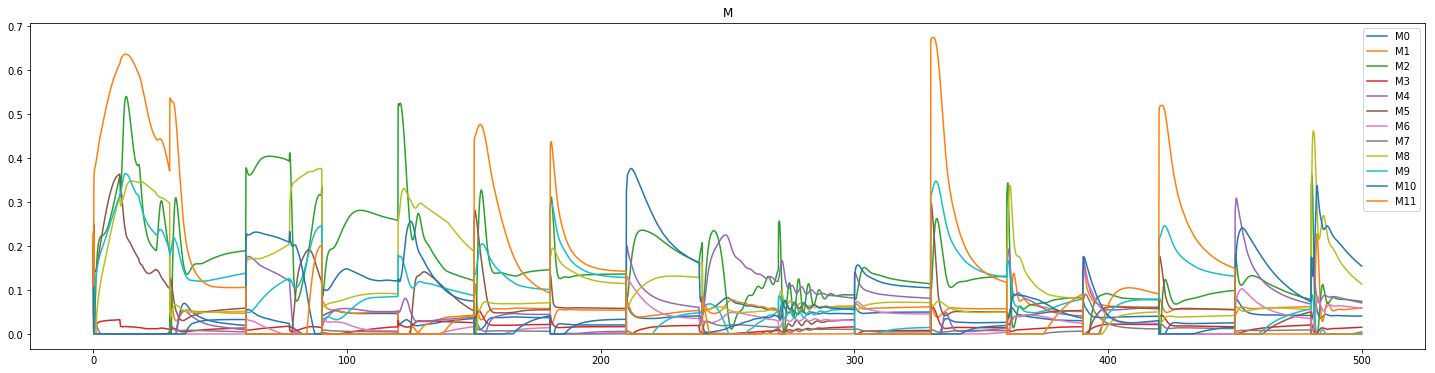

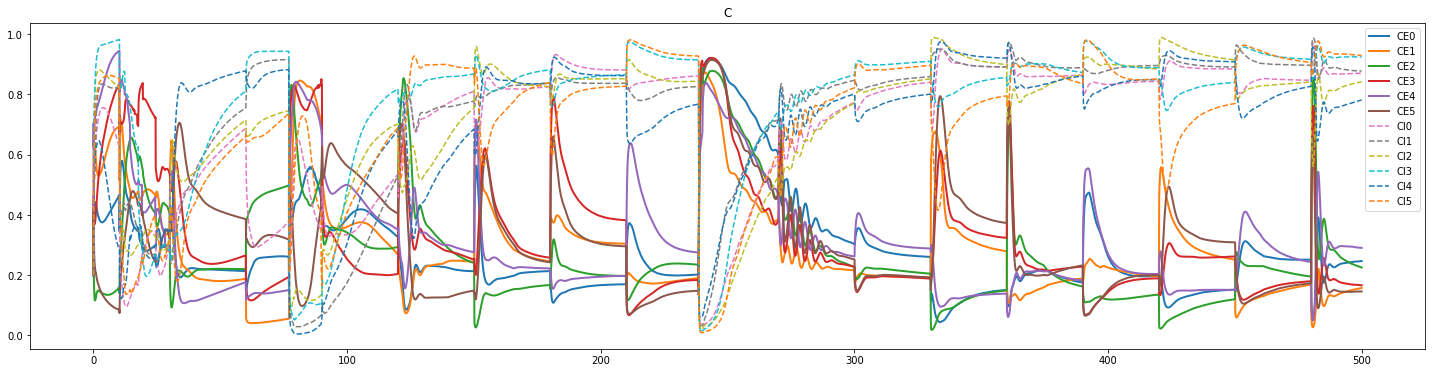

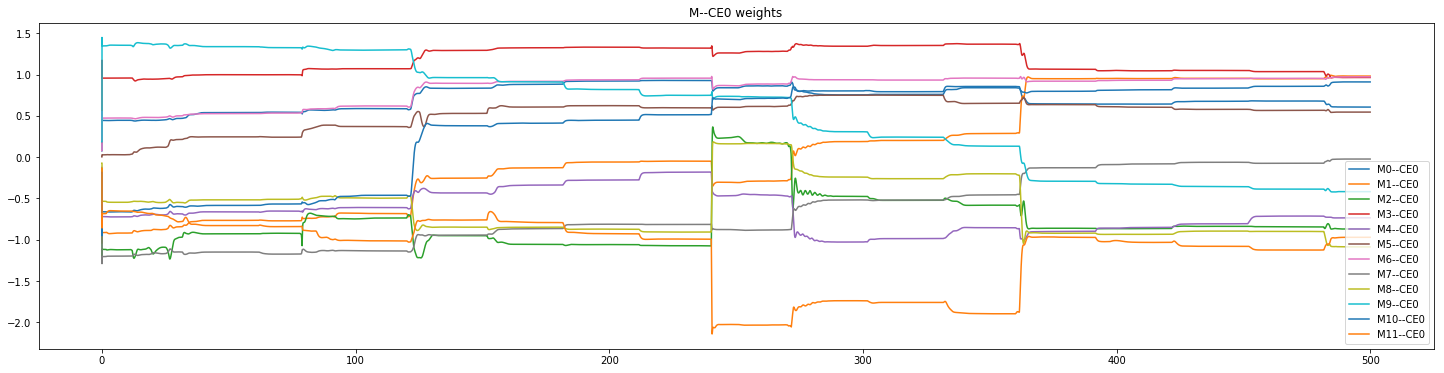

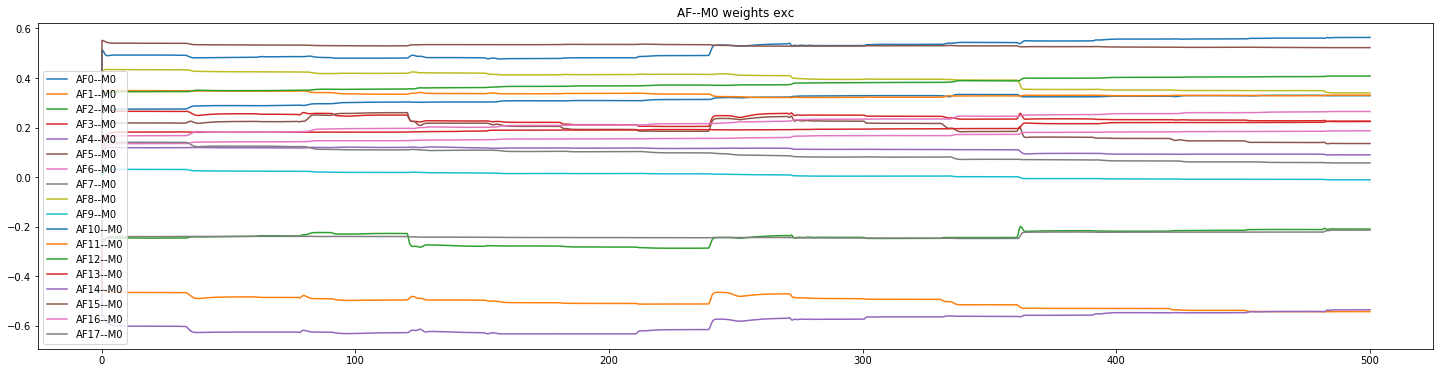

In [10]:
arm_activs = plant_data[P]
# SPF
fs = (25,6)
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF])
plt.plot(times, SPF_data.transpose())
SPF_legends = ['SPF'+str(i) for i in range(len(SPF))]
plt.legend(SPF_legends)
plt.title('SPF')
print(SPF_data[:,-1])

# M
M_fig = plt.figure(figsize=fs)
M_data = np.array(data[M])
plt.plot(times, M_data.transpose())
M_legends = ['M'+str(i) for i in range(len(M))]
plt.legend(M_legends)
plt.title('M')
print(M_data[:,-1])

# C
C_fig = plt.figure(figsize=fs)
CE_data = np.array(data[CE])
CI_data = np.array(data[CI])
plt.plot(times, CE_data.transpose(), linewidth=2)
plt.plot(times, CI_data.transpose(), '--')
C_legends = ['CE'+str(i) for i in range(len(CE))]
C_legends += ['CI'+str(i) for i in range(len(CI))]
plt.legend(C_legends)
plt.title('C')

# M--CE0 weights
W_fig1 = plt.figure(figsize=fs)
w_track_data = np.array(data[M_CE_track])
plt.plot(times, w_track_data.transpose())
M_CE0_legends = ['M'+str(i)+'--CE0' for i in range(len(M_CE_track))]
plt.legend(M_CE0_legends)
plt.title('M--CE0 weights')

# AF--M0 weights
W_fig2 = plt.figure(figsize=fs)
w_track_data2 = np.array(data[AF_M0_track[0:18]])
plt.plot(times, w_track_data2.transpose())
AF_M0_legends = ['AF'+str(i)+'--M0' for i in range(len(AF_M0_track[:18]))]
plt.legend(AF_M0_legends)
plt.title('AF--M0 weights exc')
"""
W_fig3 = plt.figure(figsize=fs)
w_track_data3 = np.array(data[AF_M0_track[18:]])
plt.plot(times, w_track_data3.transpose())
AF_M0_legends2 = ['AF'+str(i)+'--M0' for i in range(len(AF_M0_track[18:]))]
plt.legend(AF_M0_legends2)
plt.title('AF--M0 weights inh')
"""

plt.show()

shoulder angle: -0.211391, shoulder vel: 1.463641
AFe_data:
[0.13014216 0.15006387 0.13292573 0.12012362 0.17386602 0.19251332
 0.06583293 0.11085371 0.00206581 0.03353265 0.06494417 0.04731156
 0.22644387 0.24602693 0.08772105 0.16999724 0.17741266 0.15314914]
AFi_data:
[0.19145448 0.17234828 0.18882937 0.20078648 0.14850954 0.12901515
 0.24838371 0.20926248 0.29857161 0.27451993 0.24912358 0.26355693
 0.09154655 0.0686544  0.22977467 0.15246219 0.14485871 0.16932177]


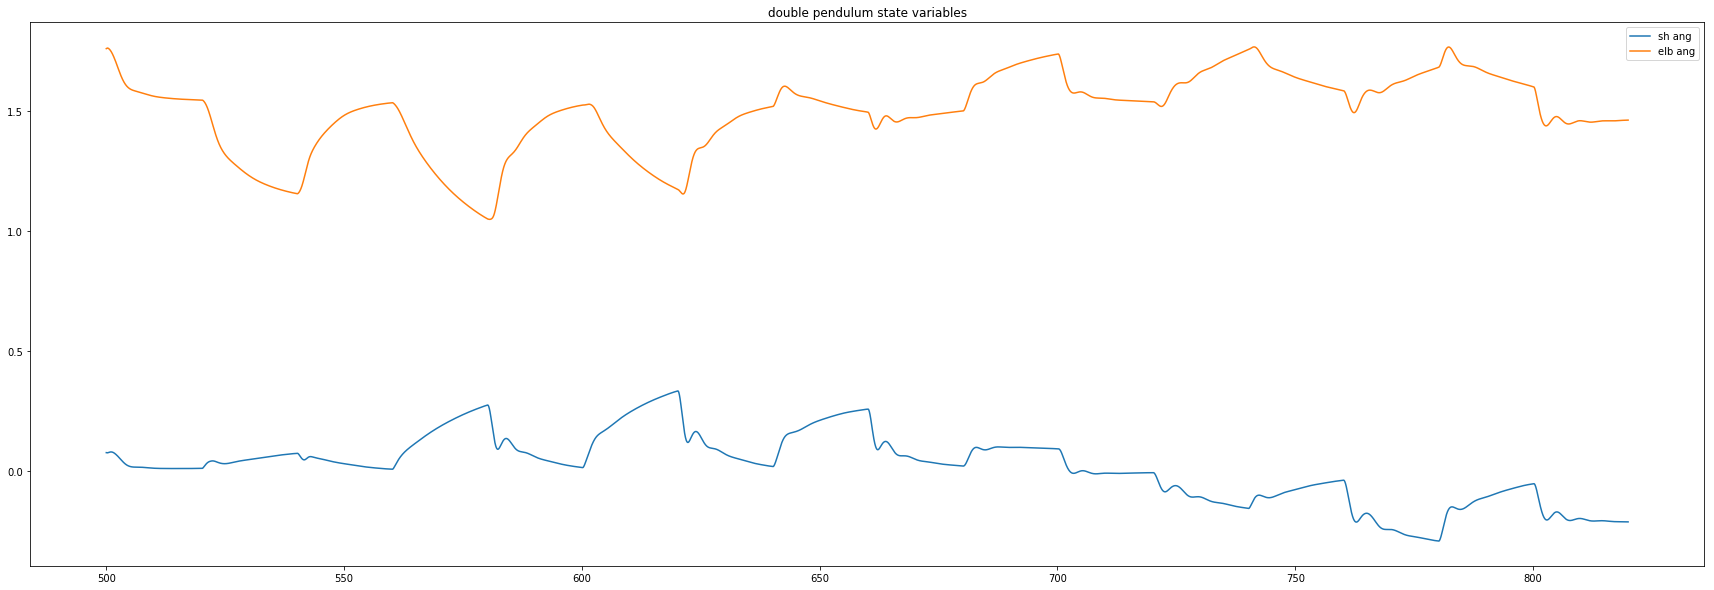

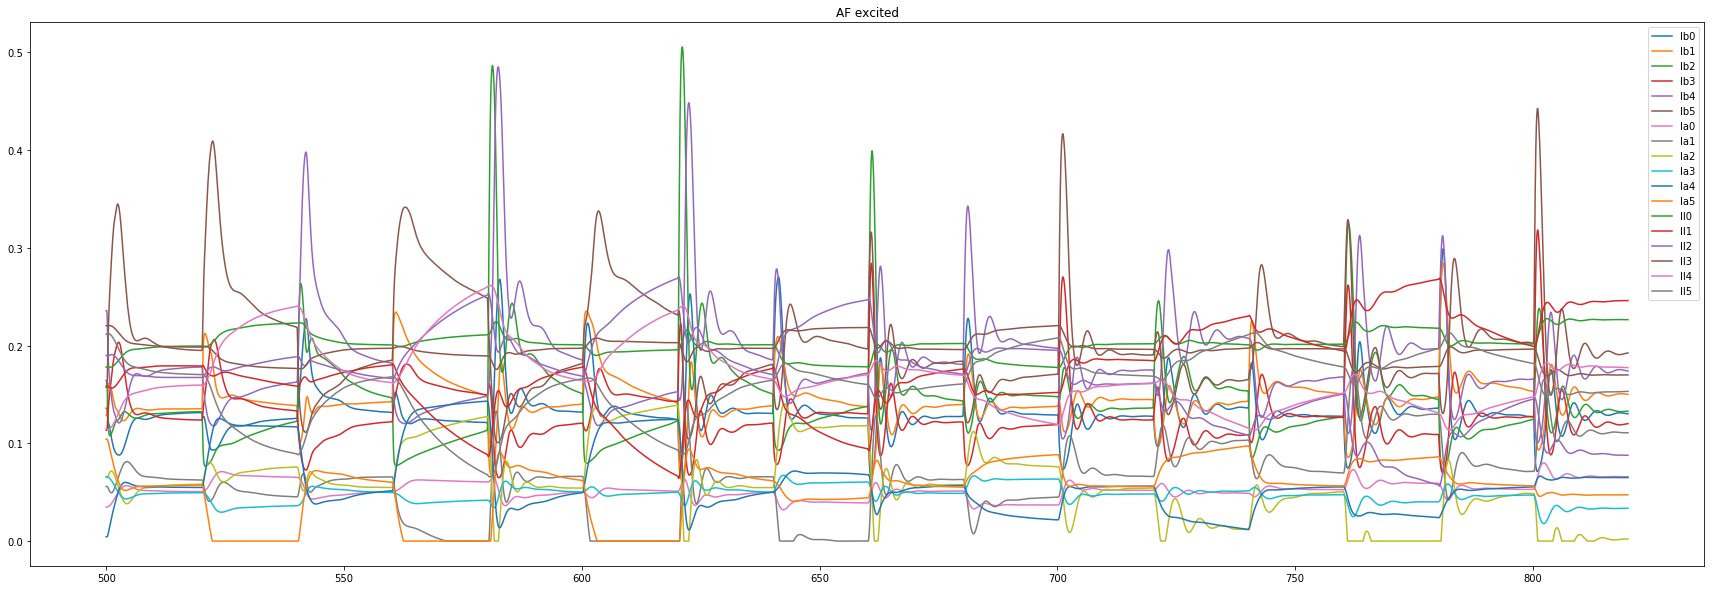

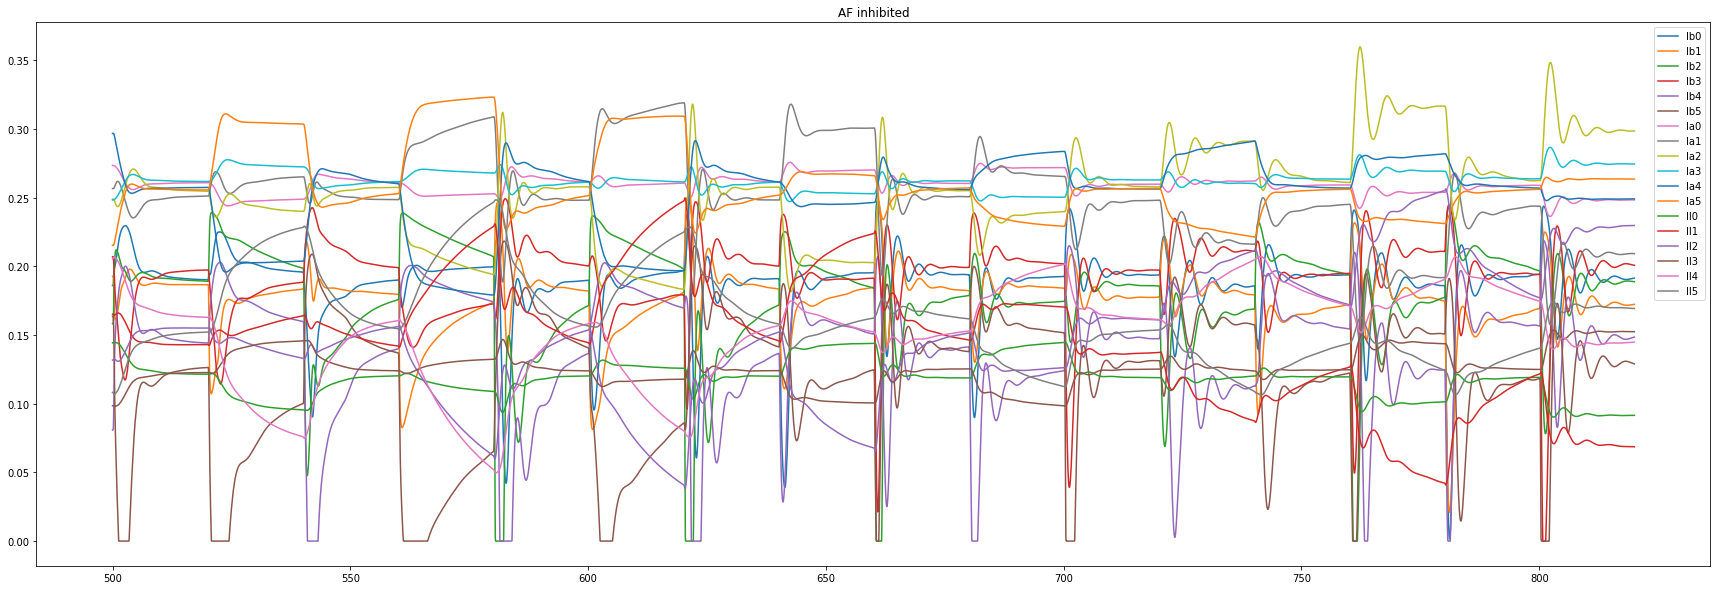

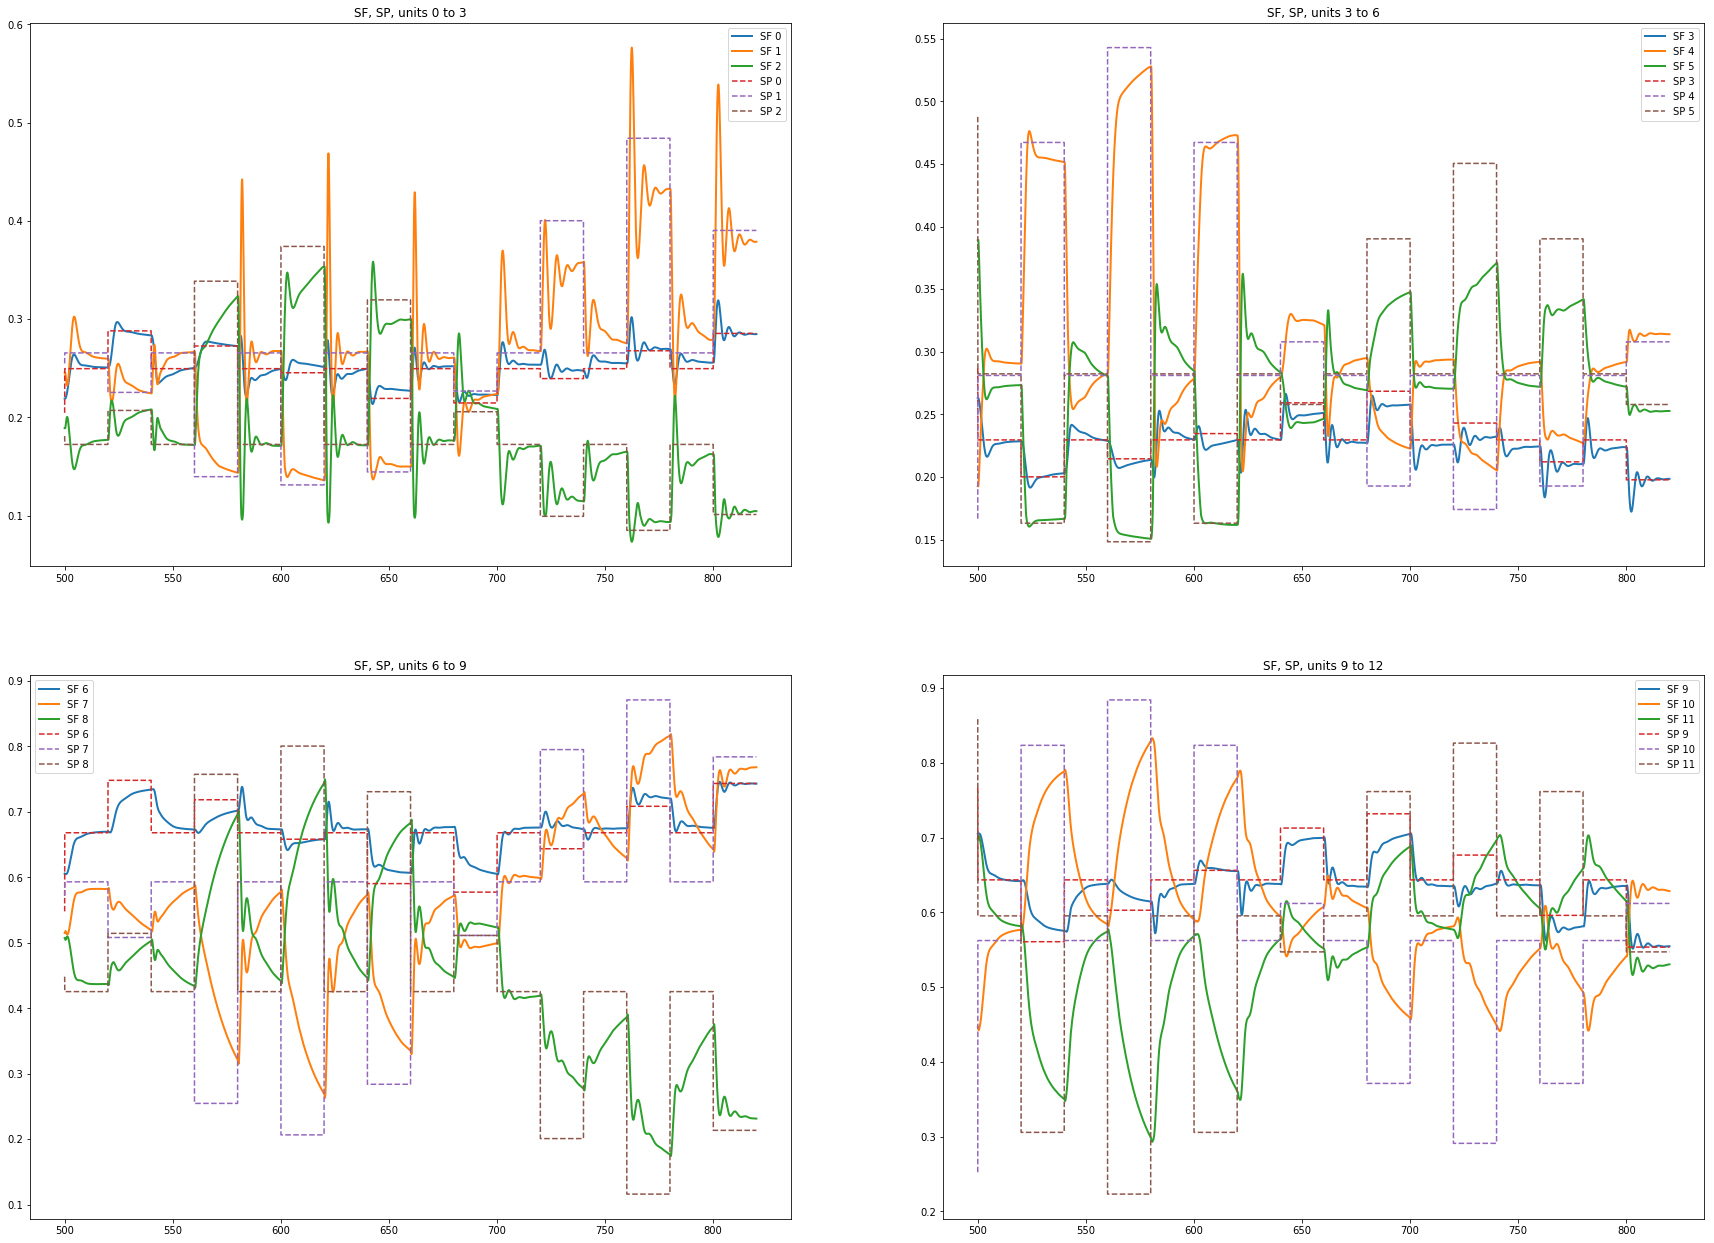

SF = 
[0.28469875 0.37881974 0.10447711 0.19847525 0.31401192 0.25268726
 0.74305696 0.76818888 0.23138237 0.55457201 0.62834154 0.53037293]
SP = 
[0.285428   0.39027606 0.1010829  0.19771375 0.30791963 0.25786656
 0.74338878 0.78404279 0.21341108 0.55340638 0.61182059 0.54700799]


In [17]:
# P
P_fig = plt.figure(figsize=fs)
P_state = plant_data[P][:,0:4:2]
plt.plot(times, P_state)
#plt.legend(['sh ang', 'sh ang vel', 'elb ang', 'elb ang vel'])
plt.legend(['sh ang', 'elb ang',])
plt.title('double pendulum state variables')
print("shoulder angle: %f, shoulder vel: %f" % (P_state[-1,0],P_state[-1,1]))

# AF plus
AFe_fig = plt.figure(figsize=fs)
AFe_data = np.array(data[AF[0:18]])
plt.plot(times, AFe_data.transpose())
AF_legends = ['Ib' + str(i) for i in range(6)] + \
             ['Ia' + str(i) for i in range(6)] + \
             ['II' + str(i) for i in range(6)]
plt.legend(AF_legends)
plt.title('AF excited')
print('AFe_data:')
print(AFe_data[:,-1])

# AF minus
AFi_fig = plt.figure(figsize=fs)
AFi_data = np.array(data[AF[18:36]])
plt.plot(times, AFi_data.transpose())
AF_legends = ['Ib' + str(i) for i in range(6)] + \
             ['Ia' + str(i) for i in range(6)] + \
             ['II' + str(i) for i in range(6)]
plt.legend(AF_legends)
plt.title('AF inhibited')
print('AFi_data:')
print(AFi_data[:,-1])

fs = (30,10)
# SF, SP
SF_fig, axs = plt.subplots(2, 2, figsize=(fs[0], 2.2*fs[1]))
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
for row in range(2):
    for col in range(2):
        ax = axs[row][col]
        base = 3*col + 6*row
        ax.plot(times, SF_data[base:base+3, :].transpose(), linewidth=2)
        ax.plot(times, SP_data[base:base+3, :].transpose(), '--')
        ax.set_title('SF, SP, units %d to %d' % (base, base+3))
        SF_legends = ['SF '+ str(base+i) for i in range(3)]
        SP_legends = ['SP '+ str(base+i) for i in range(3)]
        ax.legend(SF_legends + SP_legends)

plt.show()
print('SF = ')
print(SF_data[:,-1])
print('SP = ')
print(SP_data[:,-1])

ValueError: x and y must have same first dimension, but have shapes (64000,) and (100000, 2)

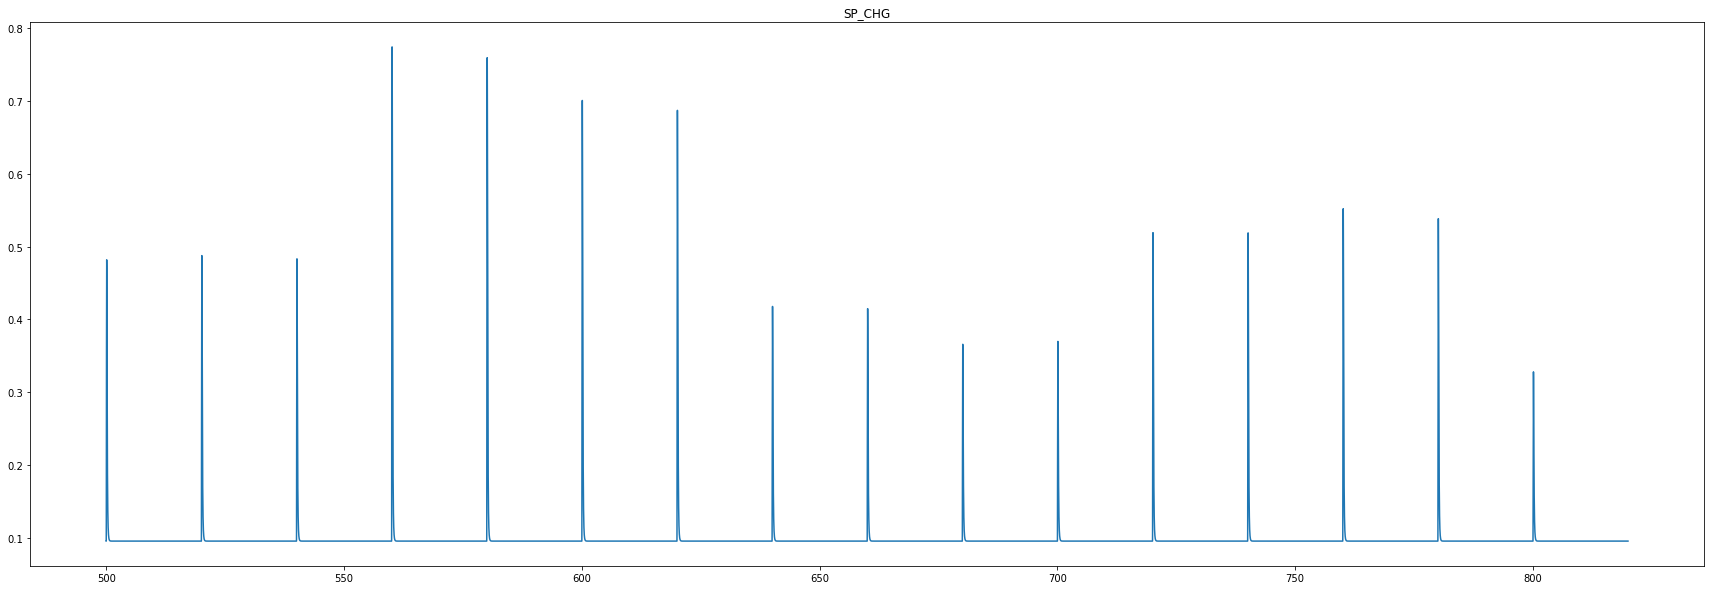

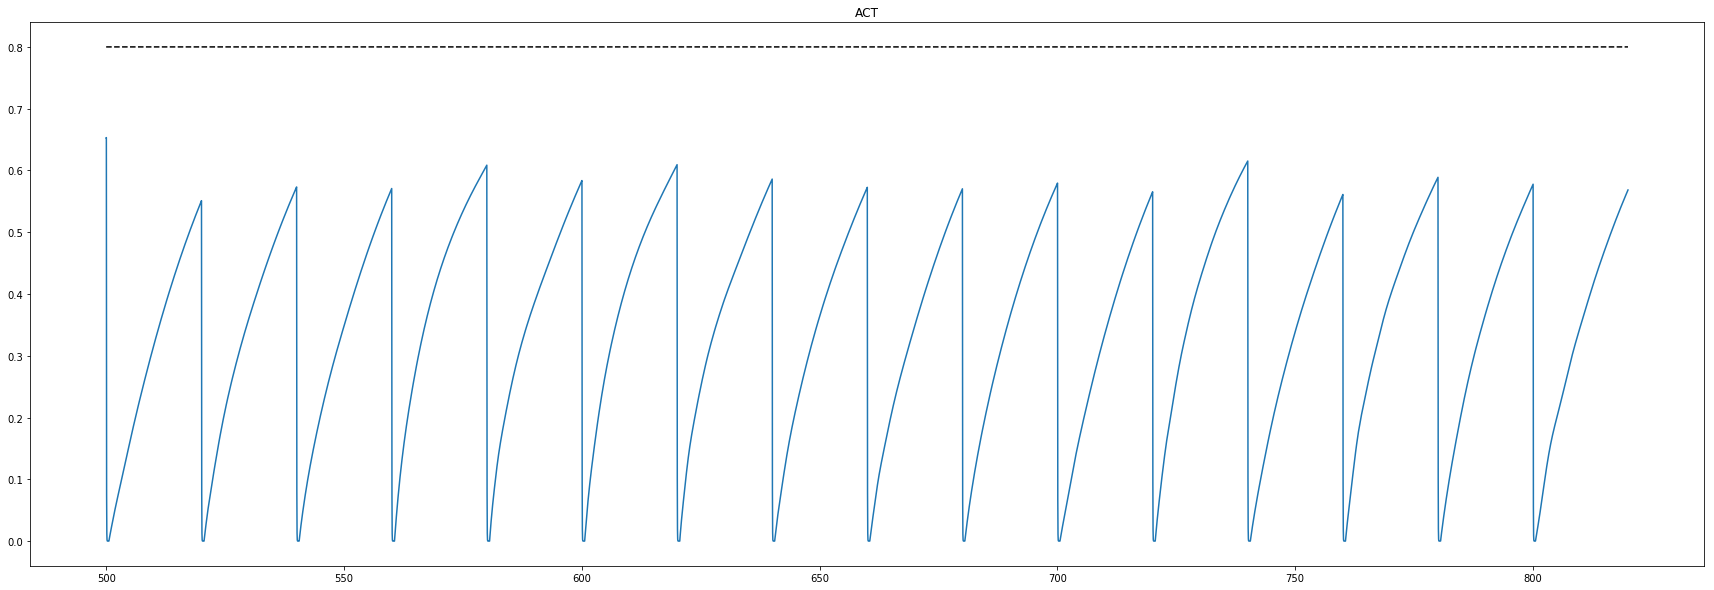

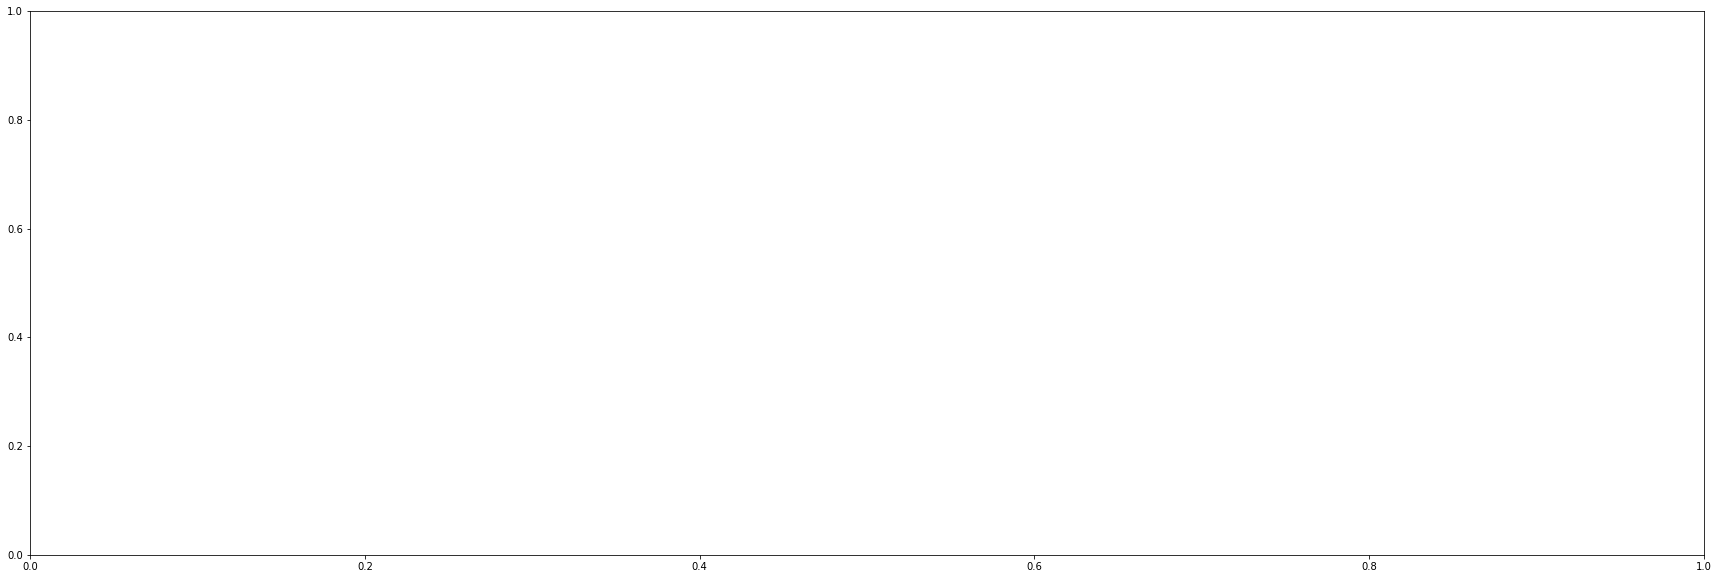

In [18]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

chg_fig = plt.figure(figsize=fs)
chg_data = np.array(data[SP_CHG])[0]
plt.plot(times, chg_data)
plt.title('SP_CHG')

act_fig = plt.figure(figsize=fs)
act_data = np.array(data[ACT])[0]
plt.plot(times, act_data)
plt.plot(times, 0.8*np.ones_like(times), 'k--')
plt.title('ACT')

plant = net.plants[P]
# modified copy-paste of plt.upd_ip_impl
q1 = arm_activs[:,0]
q2 = arm_activs[:,2]
q12 = q1+q2
c_elbow = np.array((plant.l_arm*np.cos(q1), plant.l_arm*np.sin(q1)))
c_hand = np.array((c_elbow[0] + plant.l_farm*np.cos(q12),
                   c_elbow[1] + plant.l_farm*np.sin(q12))).transpose()
if 'start_t' in locals():
    coord_idxs = np.floor((times-start_t)/t_pres).astype(int) # after resetting the targets
    des_coords = np.array([hand_coords[idx] for idx in [m_idxs[cid] for cid in coord_idxs]])
else:
    coord_idxs = np.floor(times/t_pres).astype(int)  # before resetting the targets
    des_coords = np.array(hand_coords)[m_idxs[coord_idxs],:] # desired coordinates at each moment in time
coords_fig = plt.figure(figsize=fs)
plt.plot(times, c_hand)
plt.plot(times, des_coords)
plt.title('desired vs. actual hand coordinates')
plt.legend(['X', 'Y', 'des_X', 'des_Y'])

err_fig = plt.figure(figsize=fs)
w_len = 8001
hand_error = np.linalg.norm(c_hand-des_coords, axis=1)
smooth_hand_error = smooth(hand_error, window_len=w_len)[int(np.floor(w_len/2)):-int(np.floor(w_len/2))]
plt.plot(times, smooth_hand_error)
plt.plot(times, 0.1+np.zeros(smooth_hand_error.size), 'k--')
plt.title('distance error')
avg_error = hand_error.sum()/hand_error.size
print("average error: %f" % (avg_error))

plt.show()

AL_data:
[0.10401649 0.10768488 0.10605331 0.10906561 0.10619095 0.11110439]


ValueError: x and y must have same first dimension, but have shapes (64000,) and (100000,)

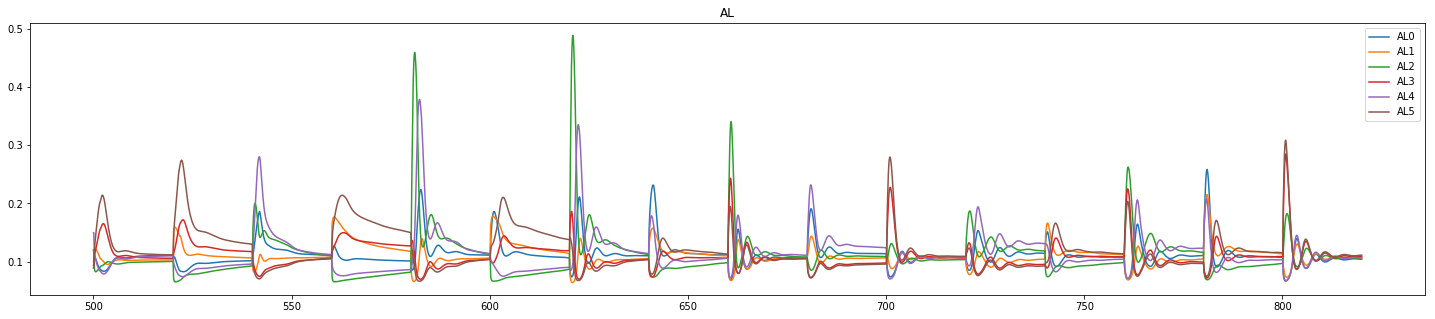

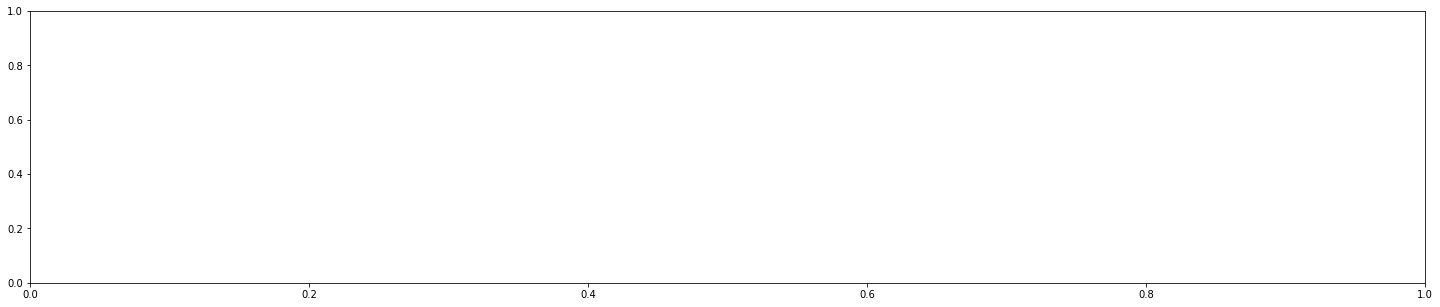

In [20]:
# Alpha units
fs2 =(25,5)
AL_fig = plt.figure(figsize=fs2)
AL_data = np.array(data[AL])
plt.plot(times, AL_data.transpose())
AL_legends = ['AL'+str(i) for i in range(len(AL))]
plt.legend(AL_legends)
plt.title('AL')
print('AL_data:')
print(AL_data[:,-1])

# plotting muscle outputs
#fs = (20,5)
legs = ['Ib', 'Ia', 'II']

for i in range(6):
    next_fig = plt.figure(figsize=fs2)
    Ib = arm_activs[:,22+i]
    Ia = arm_activs[:,28+i]
    II = arm_activs[:,34+i]
    plt.plot(times, Ib, times, Ia, times, II)
    #plt.plot(times, Ib)
    plt.legend(legs)
    plt.title('m' + str(i))
    print('Ib avg for muscle '+ str(i) + '= ' + str(np.mean(Ib)))
    print('Ia avg for muscle '+ str(i) + '= ' + str(np.mean(Ia)))
    print('II avg for muscle '+ str(i) + '= ' + str(np.mean(II)))
plt.show()

In [14]:
# set new targets
t_pres = 20. # new presentation time
start_t = net.sim_time # starting time for new simulation
# 8 radial targets in sequence, from 0 to 315 degrees
r = 0.12 # distance from center to targets
center = np.array([0.3, 0.3]) # initial hand location
n_trgs = 8 # number of targets
angs = np.linspace(0., 2.*np.pi, n_trgs+1)[:-1]
circle = np.array([np.array([np.cos(ang),np.sin(ang)]) for ang in angs])
targets = center + r*circle # coordinates of the targets
hand_coords = [center, targets[0],
               center, targets[1],
               center, targets[2],
               center, targets[3],
               center, targets[4],
               center, targets[5],
               center, targets[6],
               center, targets[7]]

hand_coords = 10*hand_coords # many repetitions of the same sequence
#### next is a copy-pasta of the code to set the SP values
# list with muscle lengths corresponding to the hand coordinates
m_lengths = []
for coord in hand_coords:
    m_lengths.append(arm.coords_to_lengths(coord))
m_lengths = np.array(m_lengths)
#(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
# We need to translate these lengths to corresponding SF activity levels.
# For that it is necessary to recreate all their transformations
# The first transformation is from length to Ia, II afferent activity.
### OUT OF THE 36 AFFERENT SIGNALS, WE TAKE THE Ia AND II ###
par = net.plants[P].m_params
# steady state tensions in the static and dynamic bag fibers (no gamma inputs)
Ts_ss = (par['k_se_s']/(par['k_se_s']+par['k_pe_s'])) * (
         par['k_pe_s']*(m_lengths - par['l0_s']))
Td_ss = (par['k_se_d']/(par['k_se_d']+par['k_pe_d'])) * (
         par['k_pe_d']*(m_lengths - par['l0_d']))
# steady state afferent outputs (no gamma inputs)
Ia_ss = par['fs']*(Ts_ss/par['k_se_s']) + (1.-par['fs'])*(Td_ss/par['k_se_d'])
II_ss = par['se_II']*(Ts_ss/par['k_se_s']) + ((1.-par['se_II'])/par['k_pe_s'])*Ts_ss
Ia_ss *= par['Ia_gain']
II_ss *= par['II_gain']
Ia_II_ss = np.concatenate((Ia_ss, II_ss), axis=1)
# Next transformation is through the afferent units
Pe__AF_ws = np.array(Pe__AF_syn['init_w'][6:18])
Pi__AF_ws = np.array(Pi__AF_syn['init_w'][6:18])
#Ia_II_avgs = np.mean(Ia_II_ss, axis=0)  # when using hundreds of random targets
# target averages
AFe_thr = np.array([net.units[u].thresh for u in AF[6:18]])
AFi_thr = np.array([net.units[u].thresh for u in AF[24:36]])
AFe_Ia_II = np.log(1. + np.maximum((Ia_II_ss)*Pe__AF_ws - AFe_thr, 0.))
AFi_Ia_II = np.log(1. + np.maximum((Ia_II_ss)*Pi__AF_ws - AFi_thr, 0.))
#(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
# Next is from AF to SF
SF_arg = AFe__SF_syn['init_w']*AFe_Ia_II + AFi__SF_syn['init_w']*AFi_Ia_II
SF_out = 1./ (1. + np.exp(-SF_params['slope']*(SF_arg - SF_params['thresh'])))
SF_params['init_val'] = SF_out # this might cause a smooth start
# now we set the values in SP

#m_idxs = np.random.randint(len(hand_coords), size=1000) # index of all targets
m_idxs = list(range(len(hand_coords))) # reach list targets sequentially
    
AF_us = [net.units[u] for u in AF]

def SF_sigmo(idx, arg):
    """ The sigmoidal function for SF unit with index SF[idx]. """
    return 1./ (1. + np.exp(-SF_params['slope'][idx]*(arg - SF_params['thresh'][idx])))

def cur_target(t):
    """ Returns the index of the target at time t. """
    return m_idxs[int(np.floor(t/t_pres))]

def make_fun(idx):
    """ create a function for the SP unit with index 'idx'. """
    return lambda t: SF_sigmo(idx, 
                        AFe__SF_syn['init_w'][idx] * (
                        np.log(1. + max(Ia_II_ss[cur_target(t-start_t)][idx] * Pe__AF_ws[idx] - 
                        net.units[AF[6+idx]].thresh, 0.))) +
                        AFi__SF_syn['init_w'][idx] * (
                        np.log(1. + max(Ia_II_ss[cur_target(t-start_t)][idx] * Pi__AF_ws[idx] - 
                        net.units[AF[24+idx]].thresh, 0.))))
    #return lambda t: SF_out[m_idxs[int(np.floor(t/t_pres))]][idx]

for idx, u in enumerate(SP):
    net.units[u].set_function(make_fun(idx))


The following code will obtain mean firing rates corresponding to each of the 8 directions.
To do this, from the onset of a reach, until the velocity begins to decrease, a mean rate is obtained for each of the units in M.

The protocol is to first run a normal simulation until the arm is doing reaches with oscillations, ~600 seconds. Then new targets are set with the cell above, and the simulation is continued so that every target is attempted twice (which requires 32*t_pres seconds of simulated time). The mean rates are obtained from the second set of reaches.

If the initial training simulation lasts 600 seconds, and t_pres=20, the time when the reach to the first target begins (`fr_time` below) is 600 + 16*20 + 20 = 940

In [21]:
# We measure velocities for each reach.
# We define the velocity at times[i] to be the norm of the vector from the hand position at 
# times[i] to the hand position at times[i+idely], divided by (times[i+idely]-times[i]).
idely = 20 # a difference of 0.1 seconds if min_delay=0.005
# angles of shoulder and elbow
theta_s = arm_activs[:,0]
theta_e = arm_activs[:,2]
phi = theta_s + theta_e # elbow angle wrt x axis
# coordinates of hand and elbow
l1 = net.plants[P].l_arm
l2 = net.plants[P].l_farm
xe = np.cos(theta_s)*l1
ye = np.sin(theta_s)*l1
xh = xe + np.cos(phi)*l2
yh = ye + np.sin(phi)*l2
# obtaining difference vector
dv_x = xh[idely:] - xh[:-idely]
dv_y = yh[idely:] - yh[:-idely]
diff_vec = np.concatenate((dv_x.reshape(1,dv_x.size), dv_y.reshape(1,dv_y.size)), axis=0)
# obtaining the velocity vector
vels = np.linalg.norm(diff_vec, axis=0) / (times[idely:]-times[:-idely])
vels = np.concatenate((vels, np.zeros(idely))) # so it keeps the same length
dv_x = np.concatenate((dv_x, np.zeros(idely)))
dv_y = np.concatenate((dv_y, np.zeros(idely)))

ValueError: operands could not be broadcast together with shapes (99980,) (63980,) 

In [19]:
# Obtaining mean M activities from reach initiation to peak velocity
# Assuming that simulation started with a reach to central position, then 
# reaches alternated center-target-center-target every t_pres seconds.
if 'targets' in locals():
    n_trgs = len(targets) # number of targets
else:
    raise AssertionError('No targets array found!')
#---------------------------------------------------------------------------
## obtaining peak velocity times (when acceleration first becomes negative)
#---------------------------------------------------------------------------
vels_diff = vels[idely:] - vels[:-idely]
vels_diff = np.concatenate((np.zeros(idely), vels_diff)) # so it keeps the same length
# segmenting the vectors into reaches to individual peripheral targets
pr_len = int(np.round(t_pres/net.min_delay)) # number of vector entries per presentation
vels_pr = [vels[(2*trg+1)*pr_len:2*(trg+1)*pr_len] for trg in range(n_trgs)] # vels per reach
vels_diff_pr = [vels_diff[(2*trg+1)*pr_len:2*(trg+1)*pr_len] for trg in range(n_trgs)] # ditto
# for each target find index of first negative acceleration
first_neg_pr = [pr_len for _ in range(n_trgs)] # index of first negative accel per target
for trg in range(n_trgs):
    for idx in range(idely, pr_len):
        if vels_diff_pr[trg][idx] < 0:
            first_neg_pr[trg] = idx
            break
#---------------------------------------------------------------------------
# segmenting M activities per target
M_data_pr = [M_data[:,(2*trg+1)*pr_len:2*(trg+1)*pr_len] for trg in range(n_trgs)]
# obtaining means
M_means_pr = []
for trg in range(n_trgs):
    M_means_pr.append(np.mean(M_data_pr[trg][:,:first_neg_pr[trg]], axis=1))
    

In [20]:
# Obtain the preferred directions of units in M through planar regression

# The M mean rates are fit using a plane, and the preferred angle is the angle
# of the projection of this plane's normal vector onto the XY plane.
# The coefficients of the normal vector come from a 3x3 linear system,
# whose coefficients are calculated next.
#trgs = targets # original targets
trgs = targets - center #circle # targets centered at the origin
X = trgs[:,0].sum()
Y = trgs[:,1].sum()
XY = (trgs[:,0]*trgs[:,1]).sum()
X2 = (trgs[:,0]*trgs[:,0]).sum()
Y2 = (trgs[:,1]*trgs[:,1]).sum()
m = n_trgs
A = np.array([[X2, XY, X], [XY, Y2, Y], [X, Y, m]])
detA = np.linalg.det(A) # determinant of A
if detA == 0.:
    raise ValueError('Indeterminate system found!')
invA = np.linalg.inv(A)
# The RHS of the system depends on the M unit's rates
prf_angs = np.zeros(len(M)) # preferred angles, in radians
normal_vecs = [] # list with the vectors normal to the plane fitting the rates
for idx in range(len(M)): # for each M unit...
    M_means = np.array([M_means_pr[trg][idx] for trg in range(n_trgs)]) # means for this unit   
    Rx = (trgs[:,0]*M_means).sum()
    Ry = (trgs[:,1]*M_means).sum()
    R = M_means.sum()
    n = np.matmul(invA, np.array([Rx, Ry, R])) # the normal vector
    normal_vecs.append(n/np.linalg.norm(n)) # appending normalized vector
    prf_angs[idx] = np.arctan2(n[1], n[0]) # preferred angle
    # obtaining residuals, coefficient of determination, R^2
    residuals = [M_means[trg]-(n[0]*trgs[trg,0]+n[1]*trgs[trg,1]+n[2]) for trg in range(n_trgs)]
    avg_mean = R/M_means.size
    devs = [M_means[trg]-avg_mean for trg in range(n_trgs)]
    SSr = sum([r*r for r in residuals])
    SSt = sum([d*d for d in devs])
    R = 1. - (SSr/SSt)
    print(R)

0.7254836092612709
0.7736207480066244
0.8004370698078014
0.8302698428527545
0.8926681600289752
0.6354477444010467
0.6504642739891159
0.8264792320499177
0.558817562762463
0.5817372726974175
0.012999473288016206
0.05487003536037205


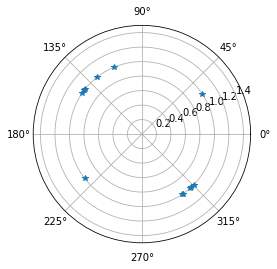

In [21]:
# plot of preferred directions for the 12 cells
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(prf_angs, np.ones(len(prf_angs)), '*')
ax.set_rmax(1.5)
plt.show()

In [22]:
# For each reach, decode the direction of movement from the M rates

# pred_v[0][i] # x component of predicted velocity at time with index t
# pred_v[1][i] # y component of predicted velocity at time with index t
pred_v = np.zeros((2,len(times)))
for idx in range(len(M)):
    pred_v[0,:] += normal_vecs[idx][0]*M_data[idx,:]
    pred_v[1,:] += normal_vecs[idx][1]*M_data[idx,:]

# Obtain the average angle between the predicted and actual velocity
norm_pred_v = pred_v[:,:-idely] # so it has the same length as diff_vec
norm_pred_v = norm_pred_v / np.linalg.norm(norm_pred_v, axis=0) # normalizing
norm_diff_vec = diff_vec / np.linalg.norm(diff_vec, axis=0)
dots = (norm_pred_v * norm_diff_vec).sum(axis=0)  # dot products for all vectors
vel_angs = np.arccos(dots)
mean_dot = np.mean(dots)
mean_vel_ang = np.arccos(mean_dot)
print(mean_vel_ang)

1.492357907756236


In [23]:
# obtaining "velocity tuning" based on correlations between M rates and directions

# Assuming the cell starting with "We measure velocities for each reach." has been executed,
# so the dv_x and dv_y vectors are already present.

# First we obtain the velocity angle at each simulation step
vel_angs = np.arctan2(dv_y, dv_x)
# Transforming the range of the angles from [-pi,pi] to [0,2pi]
vel_angs = np.mod(vel_angs+2.*np.pi, 2.*np.pi)

# Now we specify in which velocity "bin" each velocity belongs
n_bins = 16 # number of directions
ang_bit = 2.*np.pi/n_bins
vel_bins = np.floor_divide(vel_angs, ang_bit)

# Next, for each angle bin we create an array with all the M activities when the velocity
# was in the corresponding angle.
bin_arrays = []
for ang_bin in range(n_bins):
    bin_arrays.append(M_data[:,ang_bin==vel_bins])

# Finally, we obtain the mean rate of M units for each angle bin
# bin_M_means[i][j]: mean rate of j-th M unit when hand moving in direction of bin i
bin_M_means = []
for ang_bin in range(n_bins):
    if bin_arrays[ang_bin].size > 0:
        bin_M_means.append(np.mean(bin_arrays[ang_bin], axis=1))
    else:
        bin_M_means.append(np.zeros(len(M)))
            

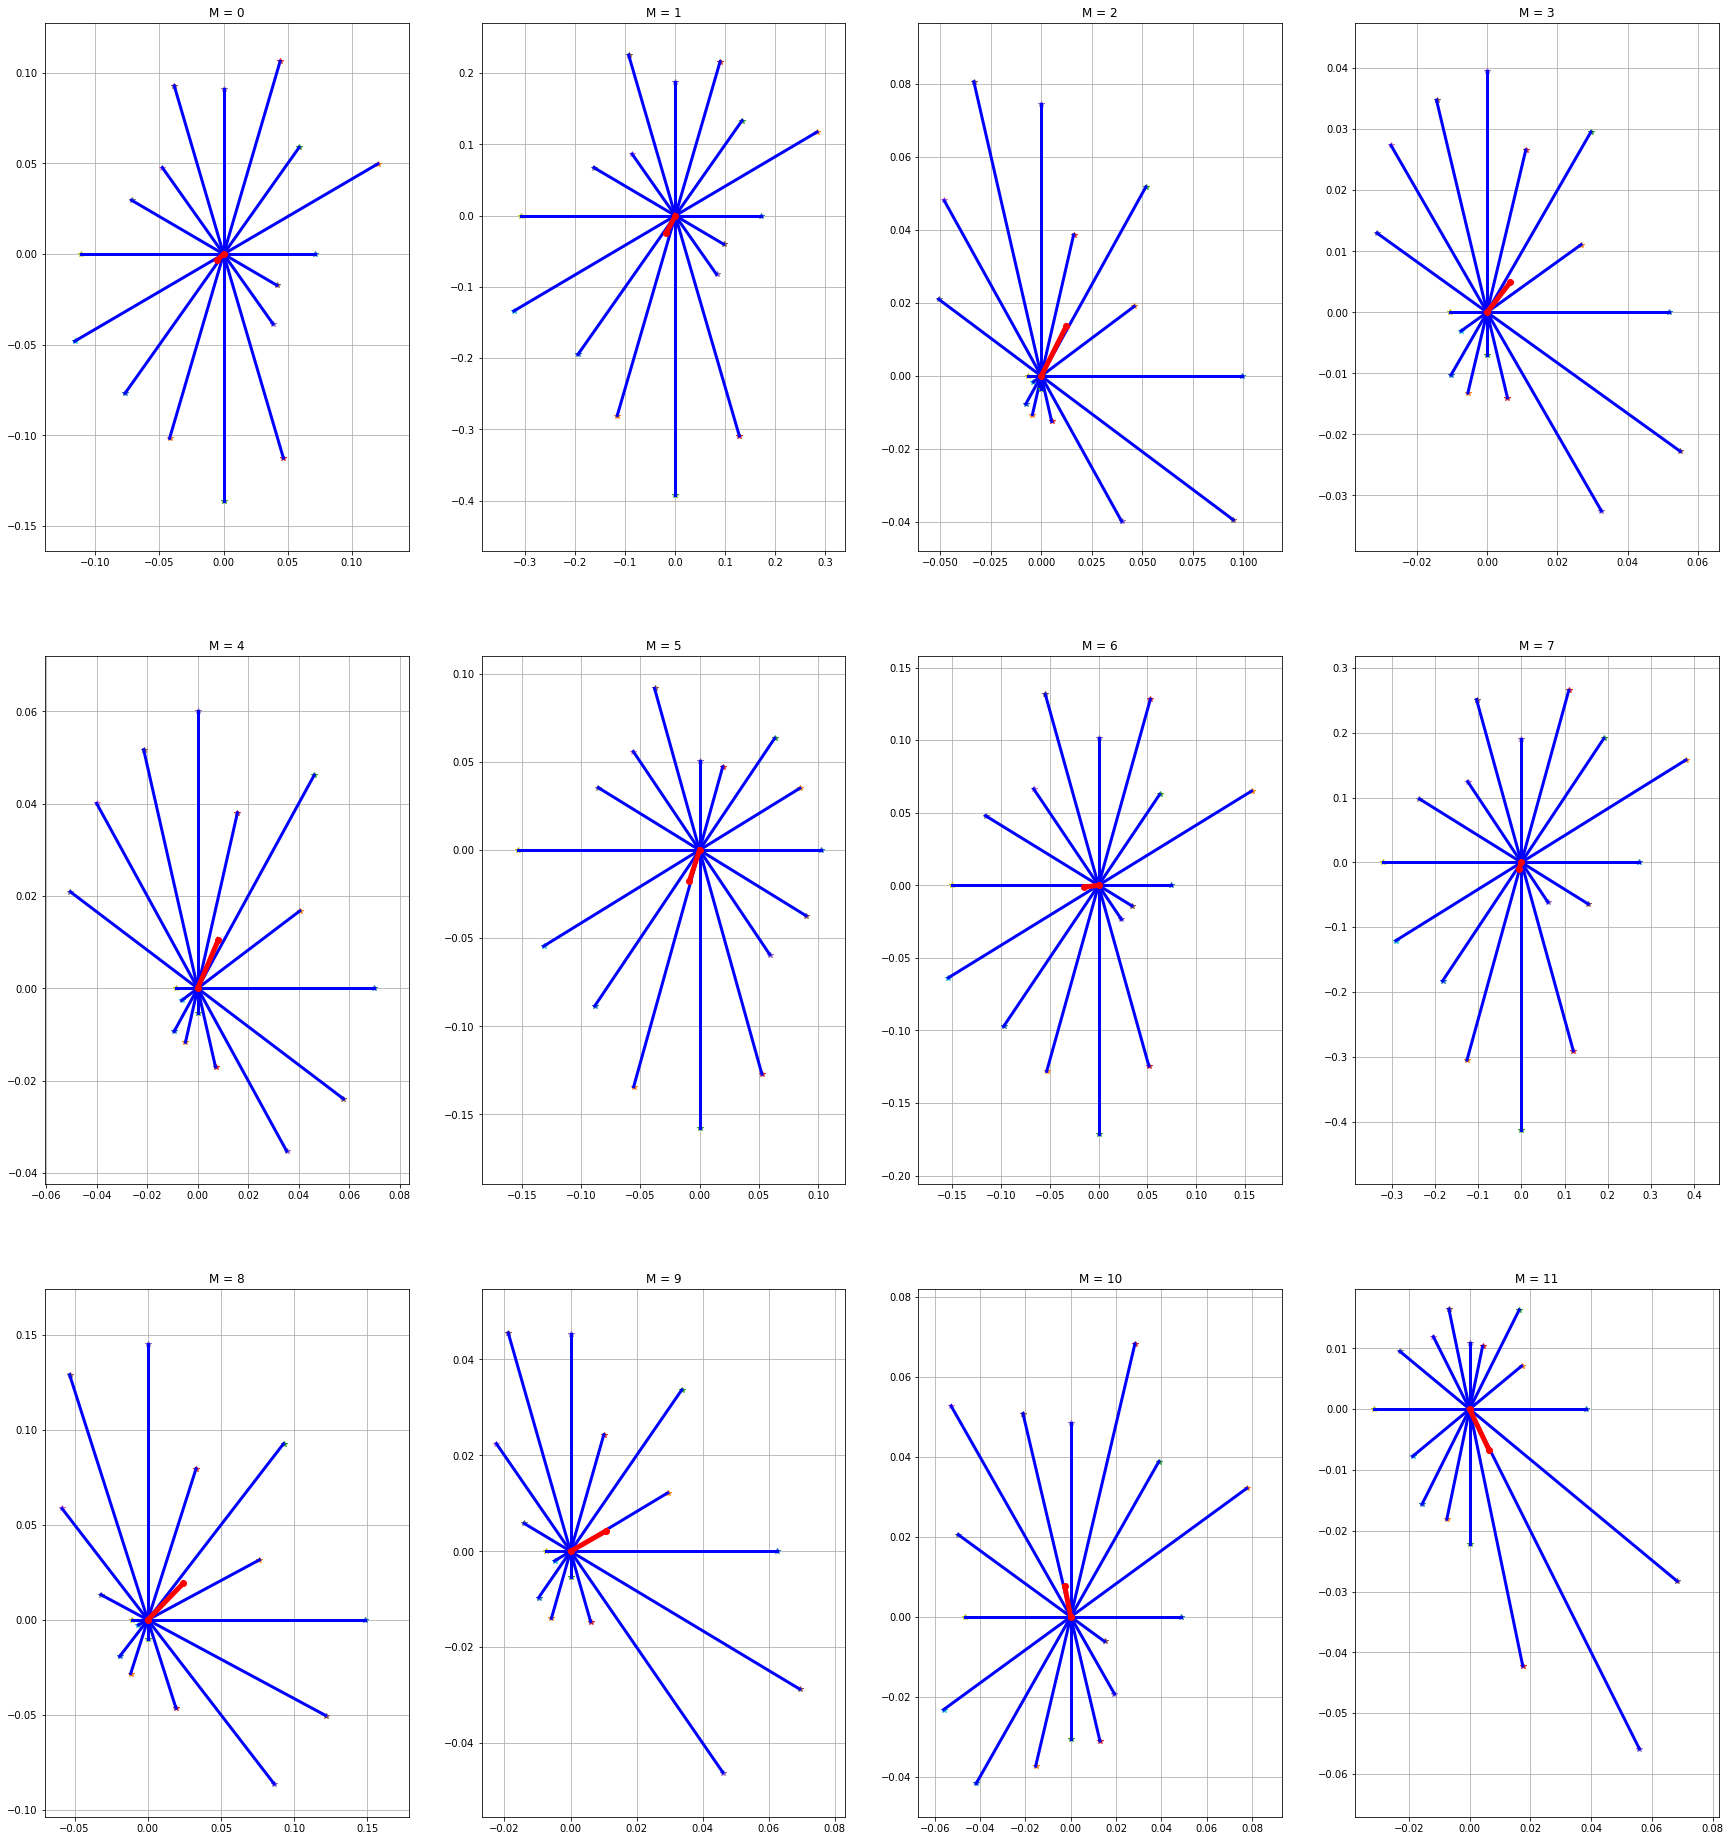

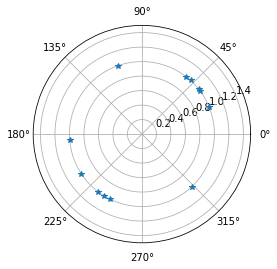

In [24]:
# Plot alternate velocity vector for all M units

# For each velocity angle, get Cartesian coordiantes of its unit vector
angles = np.linspace(0., 2.*np.pi, n_bins+1)[:-1]
x_coords = np.cos(angles) # x-coordinates of each unit velocity vector
y_coords = np.sin(angles) # y-coordinates of each unit velocity vector

# M_coords[i][j][k]: coordinates (j=0, x coordinate; j=1, y coordinate) of
# the i-th unit velocity vector scaled by the mean firing rate of the
# k-th M unit when the hand is moving in the direction of that i-th vector
M_coords = [[bin_M_means[i]*x_coords[i],bin_M_means[i]*y_coords[i]]
            for i in range(n_bins)]

# avg_vels[i][j]: for the i-th M unit the x (if j=0) or y (if j=1)
# coordinate of its preferred velocity vector, arising from an average
# of M_coords[:][j][i]
avg_vels = np.zeros((len(M), 2))
for idx in range(len(M)):
    avg_vels[idx,0] = sum([M_coords[d][0][idx] for d in range(n_bins)])/n_bins
    avg_vels[idx,1] = sum([M_coords[d][1][idx] for d in range(n_bins)])/n_bins

vel_fig, vel_axs = plt.subplots(3, 4, figsize=(fs[0], 3.3*fs[1]))

for row in range(3):
    for col in range(4):
        ax = vel_axs[row][col]
        m_id = 4*row + col
        max_x = max([M_coords[i][0][m_id] for i in range(n_bins)])
        min_x = min([M_coords[i][0][m_id] for i in range(n_bins)])
        max_y = max([M_coords[i][1][m_id] for i in range(n_bins)])
        min_y = min([M_coords[i][1][m_id] for i in range(n_bins)])
        ax.set_xlim([1.2*min_x, 1.2*max_x])
        ax.set_ylim([1.2*min_y, 1.2*max_y])
        ax.grid()
        ax.set_title("M = %d"%(m_id))
        for trg in range(n_bins):
            ax.plot([M_coords[trg][0][m_id]], [M_coords[trg][1][m_id]], '*')
            ax.plot([0., M_coords[trg][0][m_id]], [0., M_coords[trg][1][m_id]], 'b', linewidth=3)
        ax.plot([0., avg_vels[m_id][0]], [0., avg_vels[m_id][1]], 'r-o', linewidth=5)
        
# Plot the prefered directions only
prf_angs2 = np.arctan2(avg_vels[:,1], avg_vels[:,0])
prf_dir2_fig, prf_dir2_ax = plt.subplots(subplot_kw={'projection': 'polar'})
prf_dir2_ax.plot(prf_angs2, np.ones(len(prf_angs2)), '*')
prf_dir2_ax.set_rmax(1.5)

plt.show()

In [25]:
# Once more, predict velocities
# pred_v2[i][j]: x (if i=0) or y (if i=1) component of predicted
# velocity at time index 'j'
pred_v2 = np.zeros((2,len(times)))
for idx in range(len(M)):
    pred_v2[0,:] += avg_vels[idx][0]*M_data[idx,:]
    pred_v2[1,:] += avg_vels[idx][1]*M_data[idx,:]

# Obtain the average angle between the predicted and actual velocity
norm_pred_v2 = pred_v2[:,:-idely] # so it has the same length as diff_vec
norm_pred_v2 = norm_pred_v2 / np.linalg.norm(norm_pred_v2, axis=0) # normalizing
norm_diff_vec = diff_vec / np.linalg.norm(diff_vec, axis=0)
dots2 = (norm_pred_v2 * norm_diff_vec).sum(axis=0)  # dot products for all vectors
vel_angs2 = np.arccos(dots2)
mean_dot2 = np.mean(dots2)
mean_vel_ang2 = np.arccos(mean_dot2)
print(mean_vel_ang2)


1.3785937754334874


## How to interpret the plots below
**For the first two plot grids**:  
The value at `t=0` is the that comes from using the current `custom_inp_del(2)` values in the rga_diff rule.
Negative `t` values correspond to delay in the M signal, which is what makes most sense in the physical implementation. The value at `t=-x` can be interpreted as the direction of change that the rga_diff learning rule would imply if both `custom_inp_del` and `custom_inp_del2` were increased by `x` time units.


**For the third plot grid**:  
The value at `t=0` is the value of the M-C correlation when C is delayed by `custom_inp_del2`. Values to the left imply increasing the delay in C.

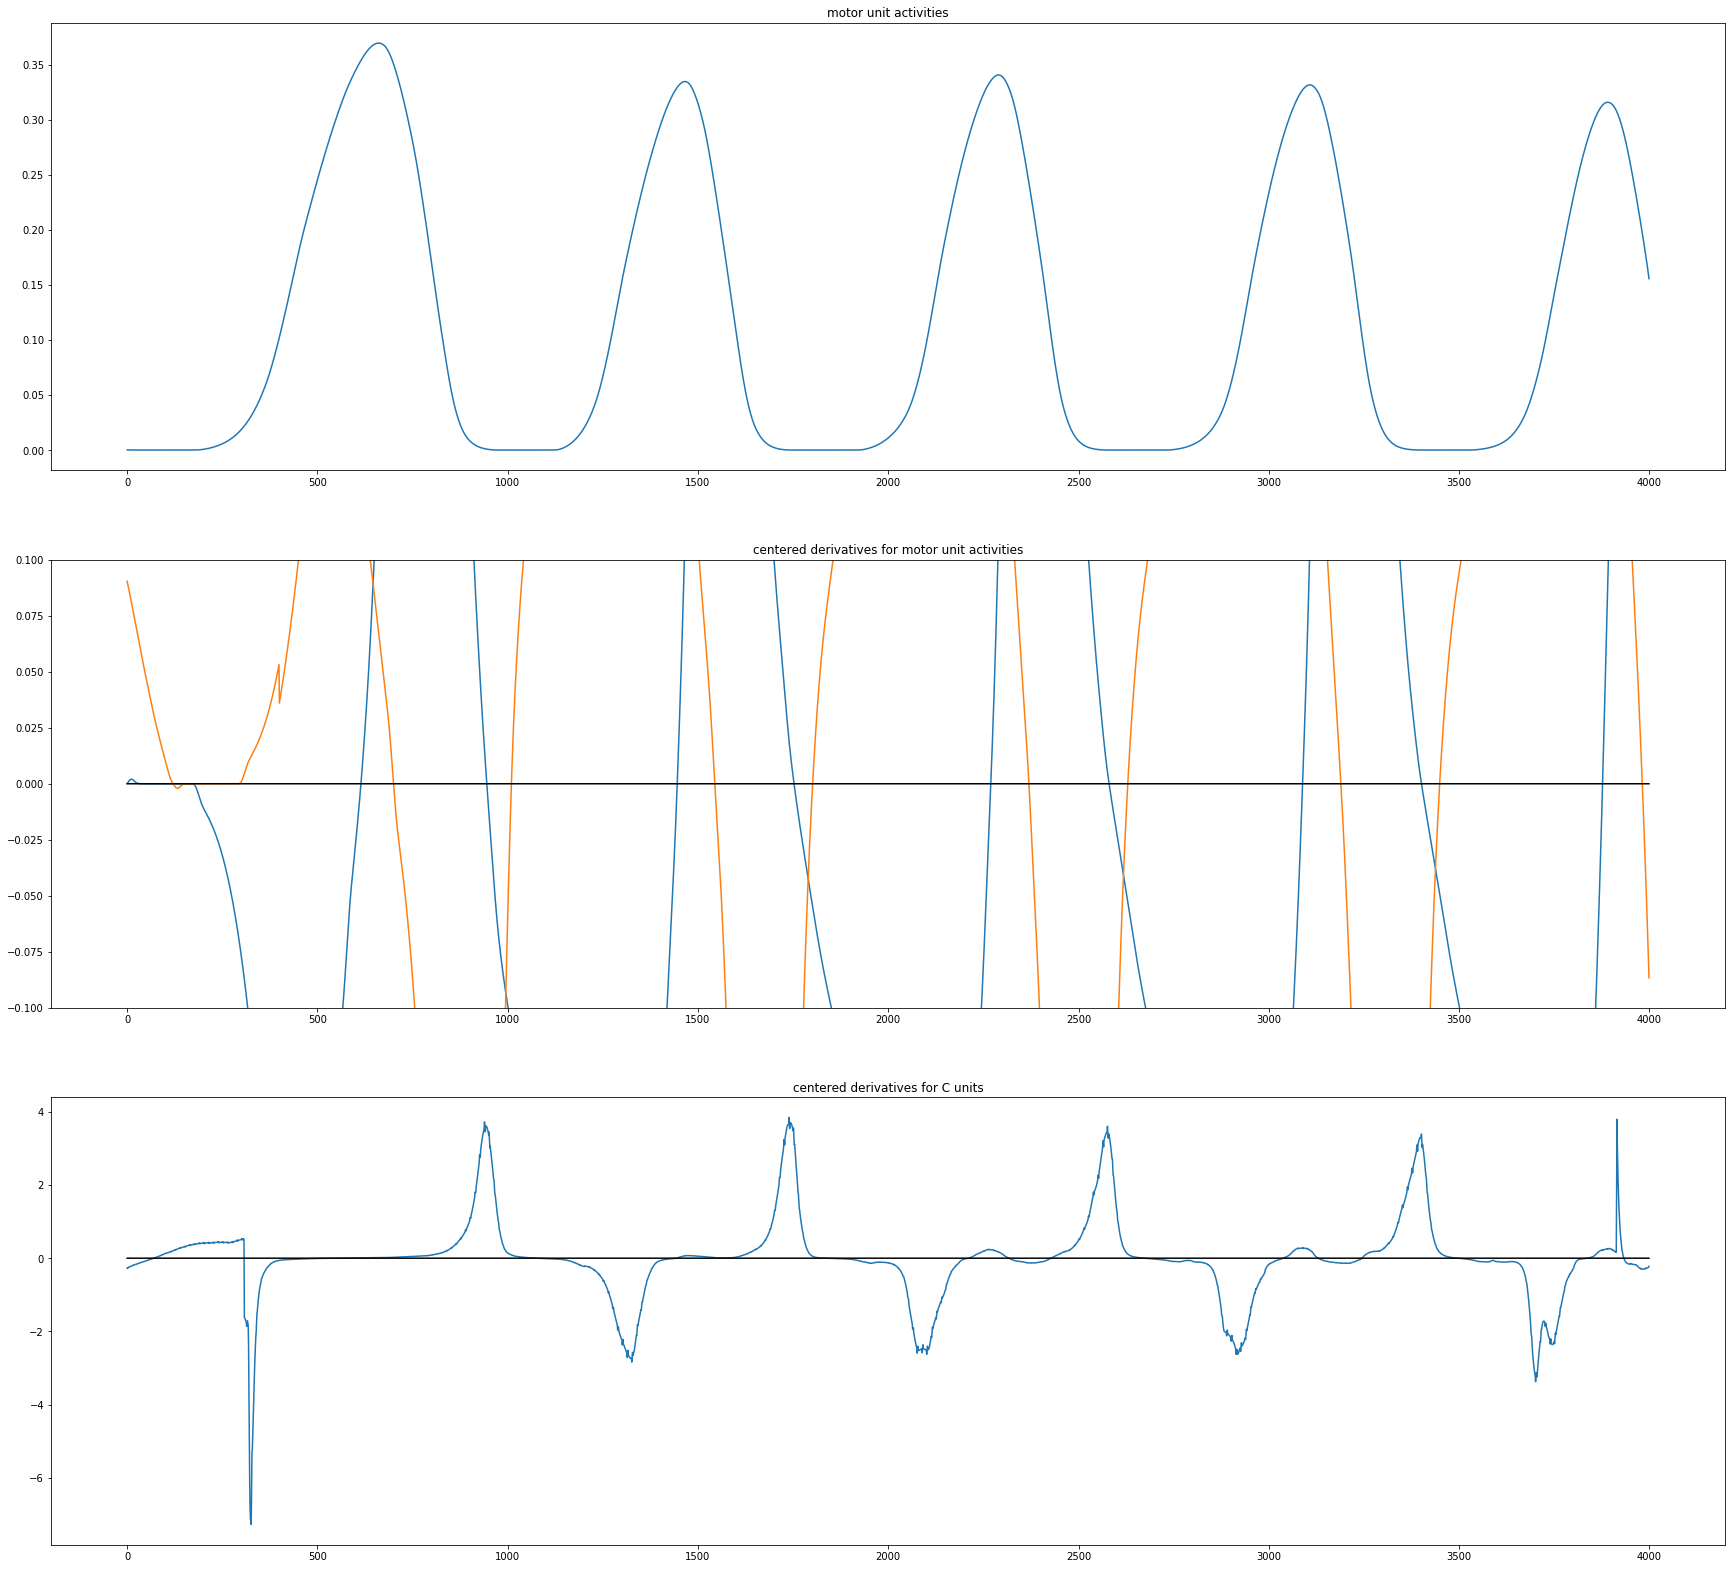

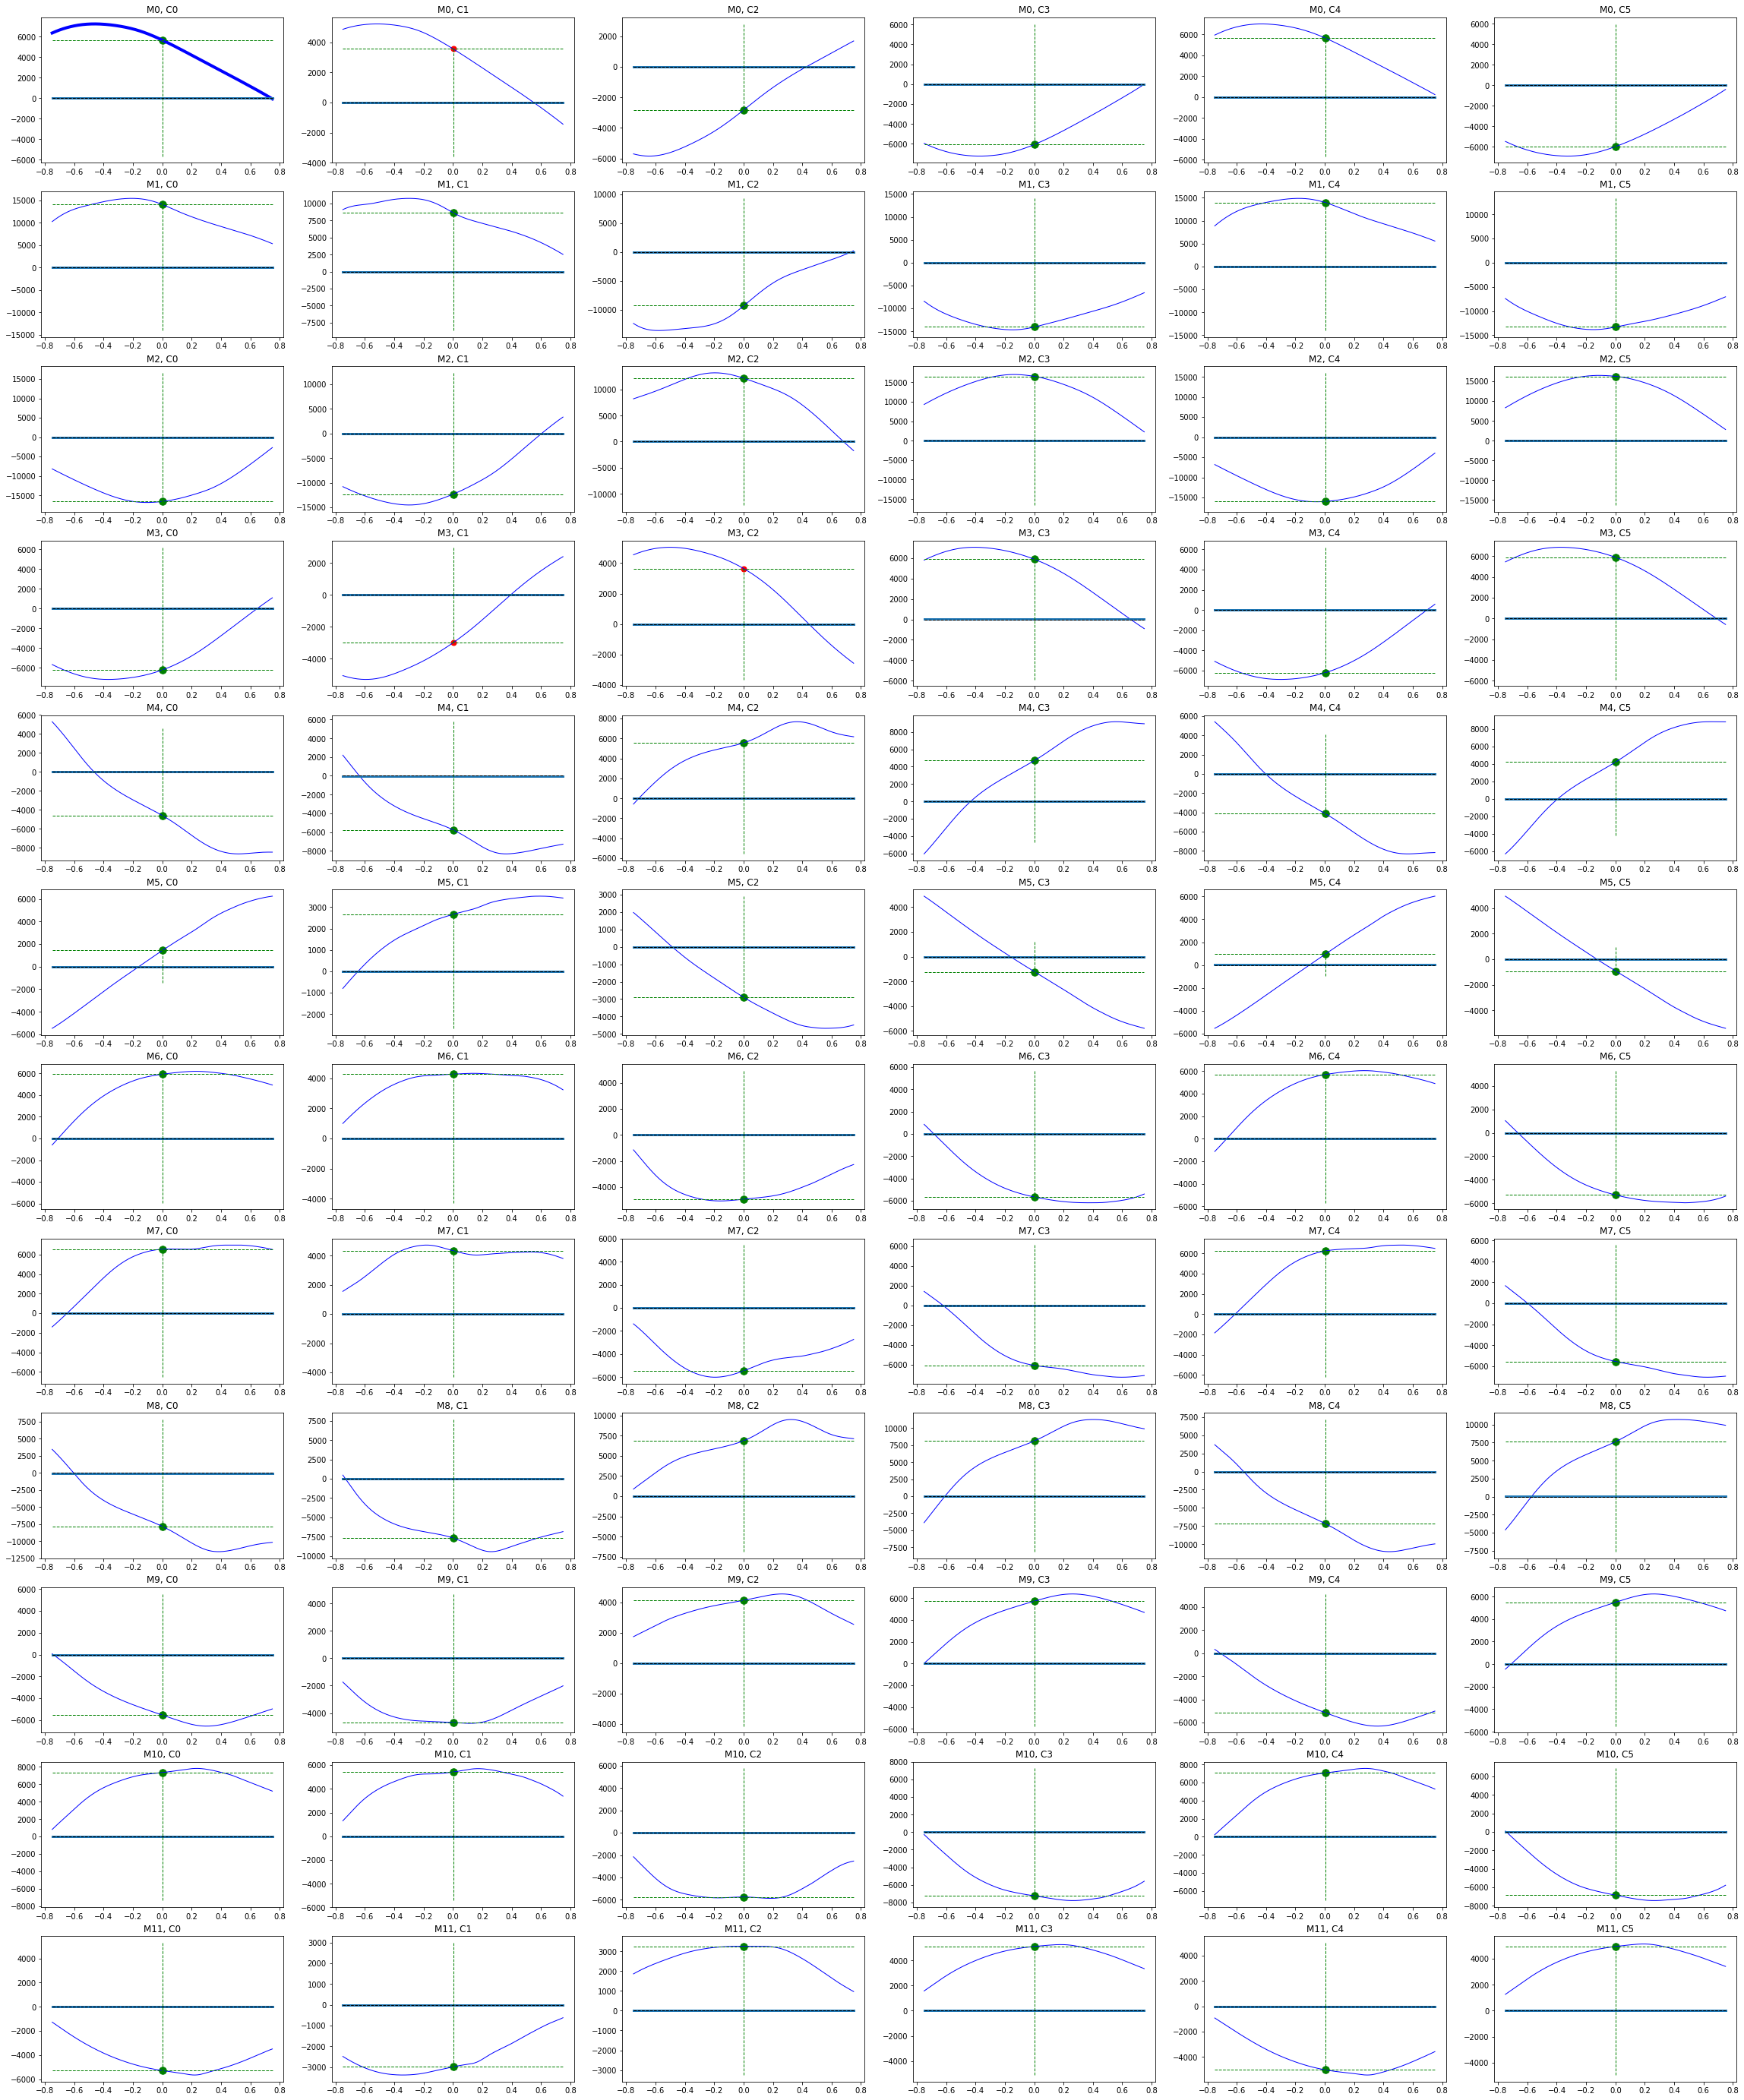

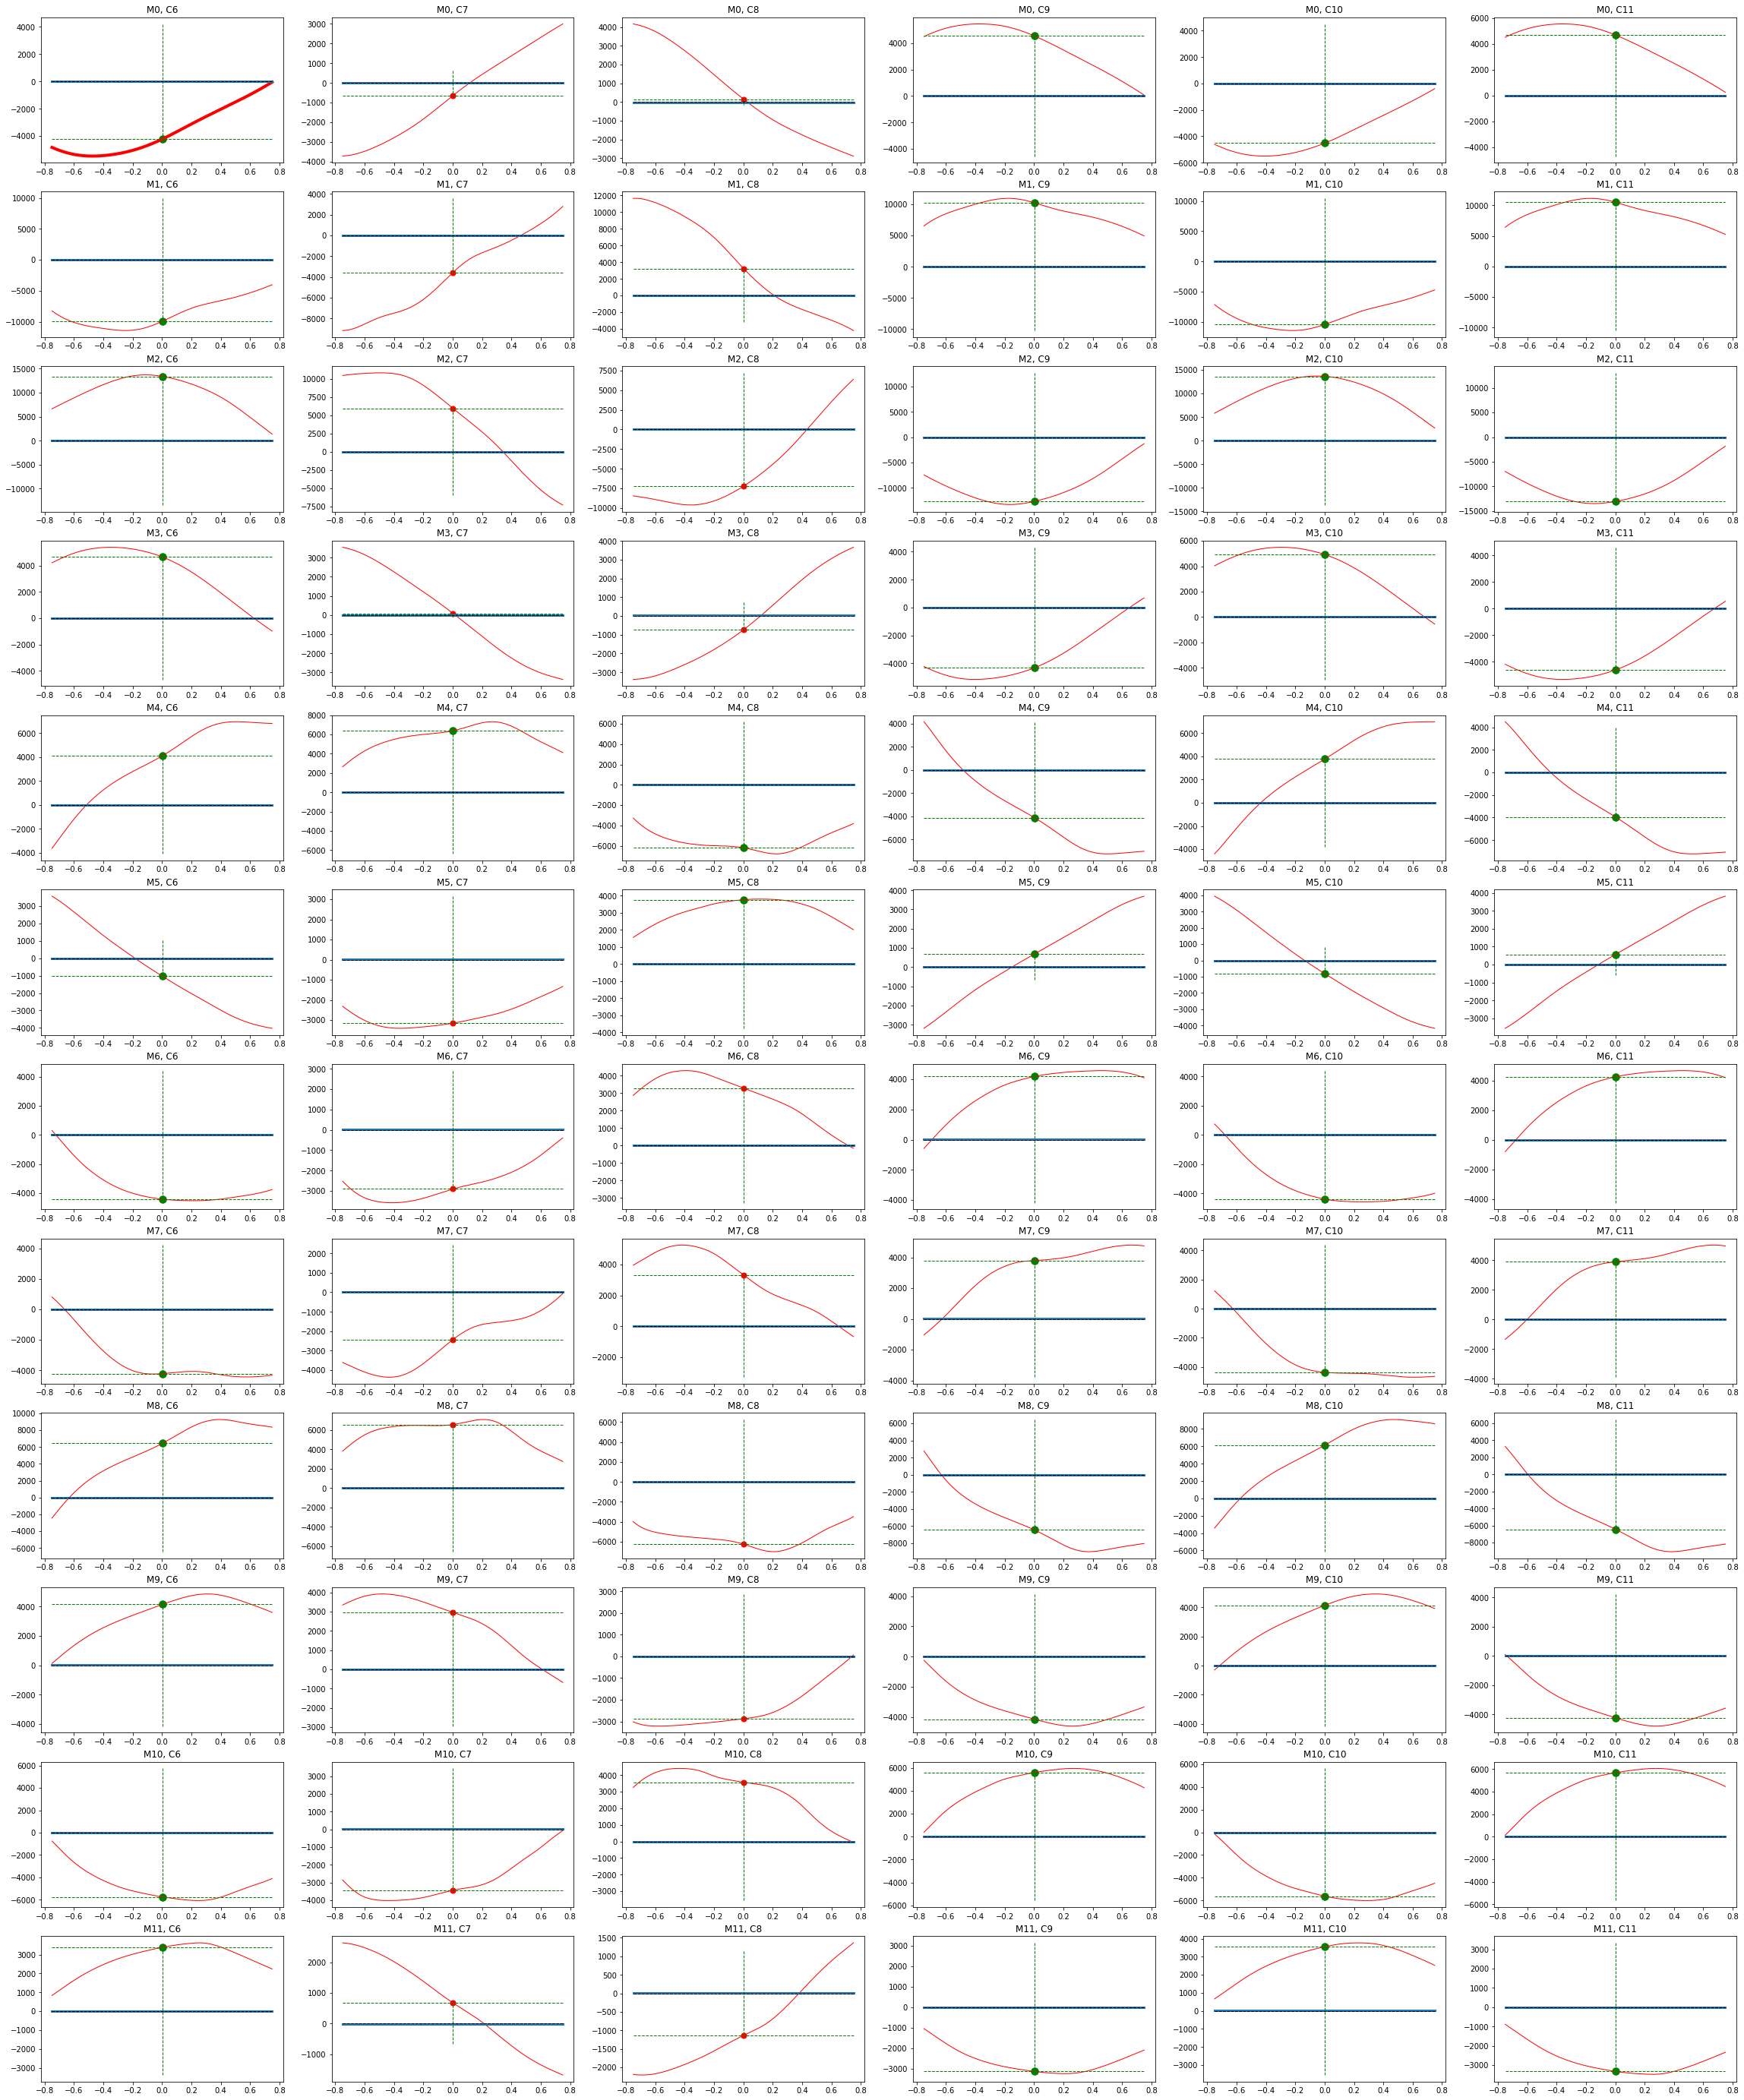

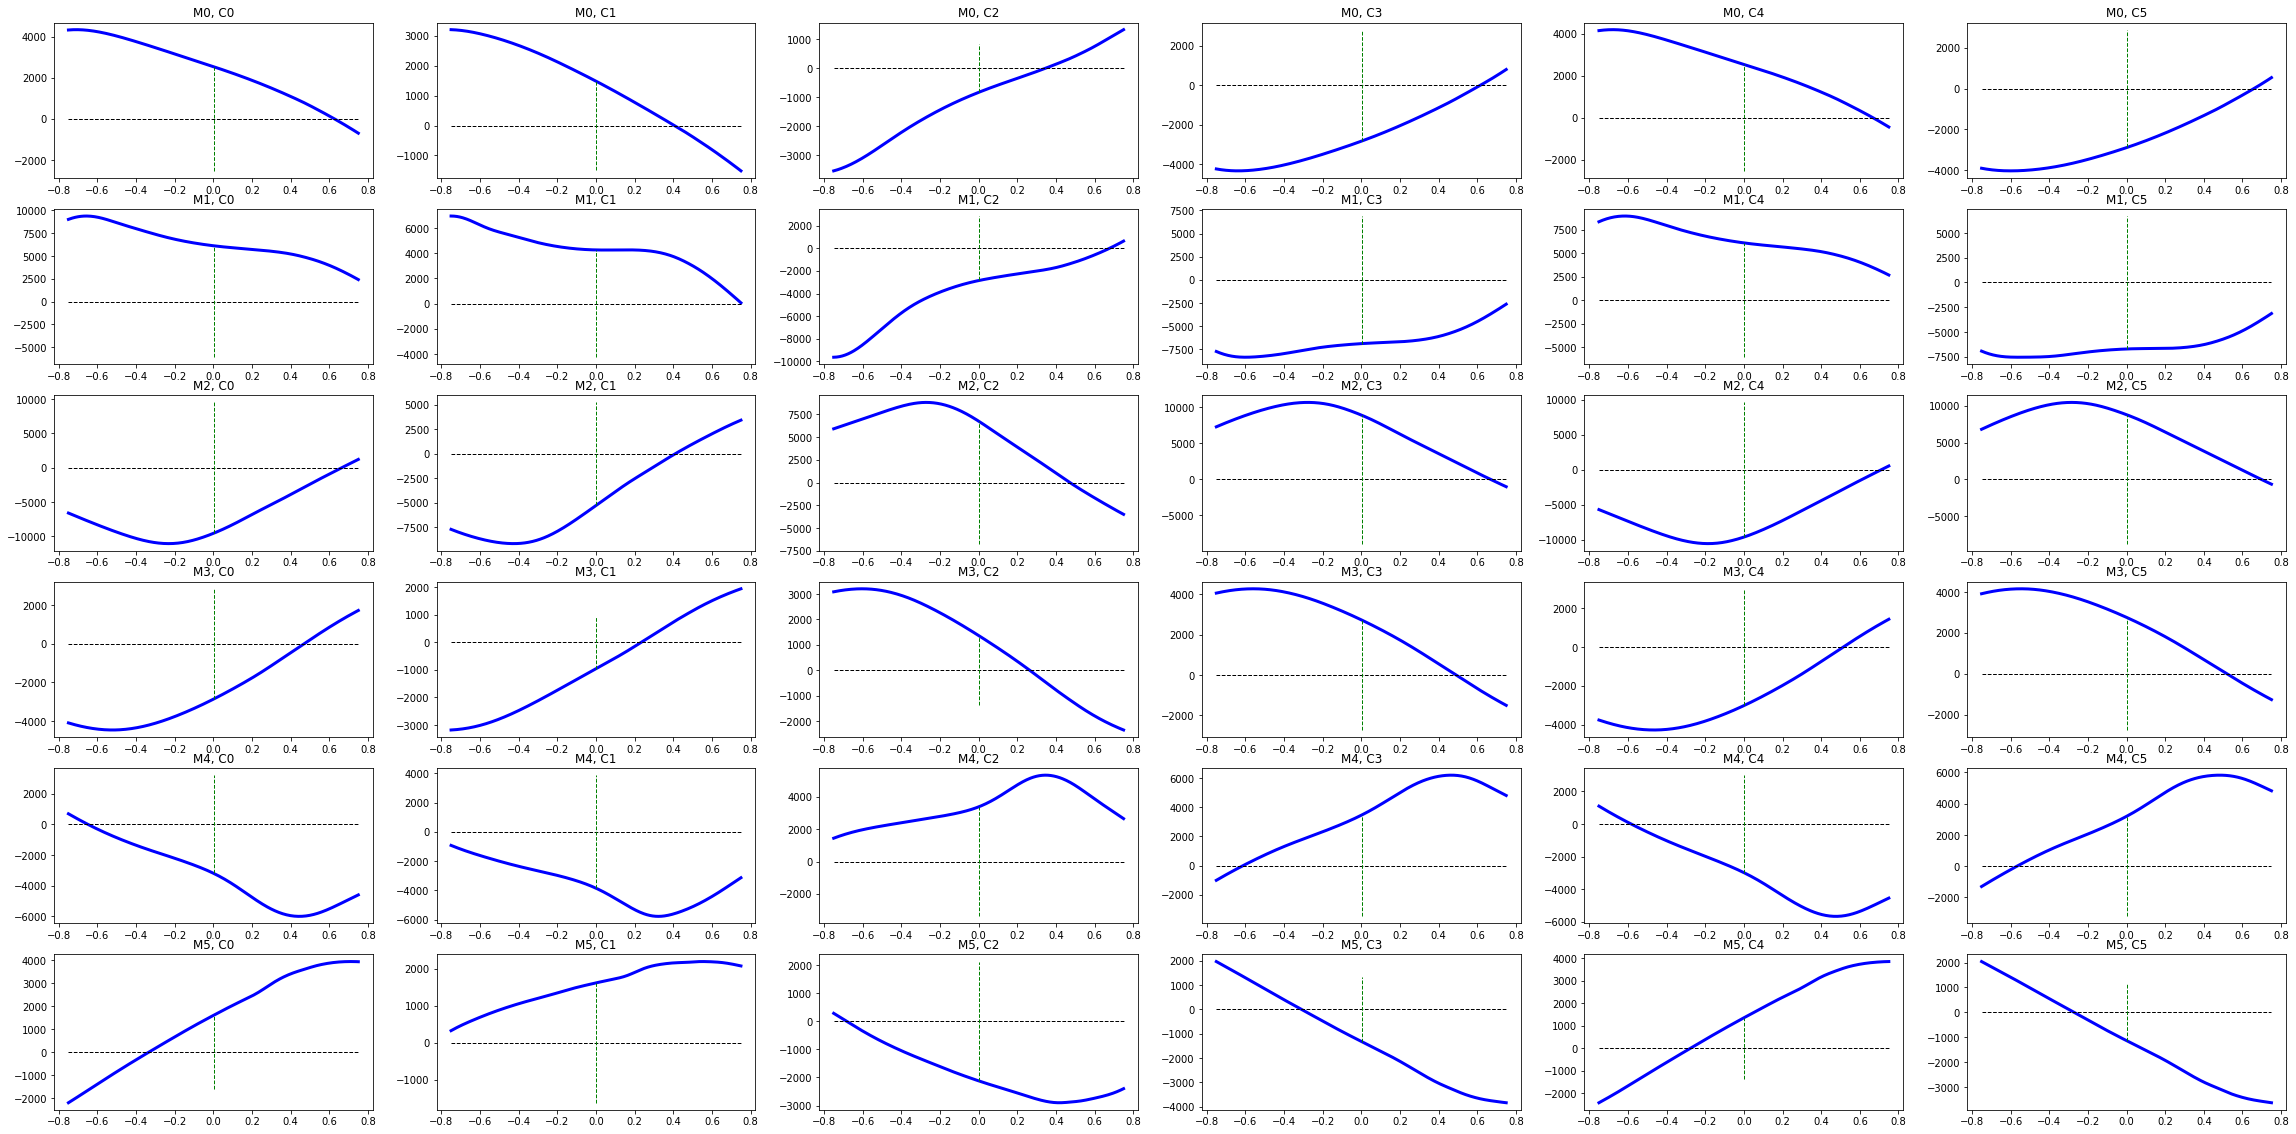

[[1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
 [1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]]
[12. 10. 11. 12. 12. 12. 12.  1.  2. 12. 12. 12.]
[ 9. 10. 10.  8. 12. 11. 10. 10. 10. 10. 10. 10.]
0.8333333333333334
normalized M__CE correlation weight matrix:
[[ 0.1972704, 0.16832779, -0.13170597, -0.21256234, 0.20476301, -0.21843811]
, [ 0.49014183, 0.41007617, -0.43538741, -0.49298941, 0.50588832, -0.48568716]
, [-0.58025521, -0.5840081, 0.56819962, 0.5795816, -0.57864764, 0.59352054]
, [-0.2168196, -0.14185377, 0.16995766, 0.20630083, -0.2245018, 0.21503294]
, [-0.16110973, -0.27357662, 0.26058917, 0.16547197, -0.1494

In [40]:
# ANALYSIS OF CORRELATIONS BETWEEN MOTOR UNITS AND C UNITS
# Modified for the rga_diff rule

# obtaining M,C unit activities and their derivatives
full_size = len(data[M[0]])
D_size = 100000 # number of points we will take from the data signals
corr_size = 1000 # number of points in the correlation vector
MD = data[M, -D_size:].transpose() # take the data from the latest points
w_l = 31 # window length for smoothing
for idx in range(len(M)): # smoothing MD
    MD[:,idx] = smooth(MD[:,idx], window_len=w_l)[int(np.floor(w_l/2)):-int(np.floor(w_l/2))]
MD_diff = np.gradient(MD, axis=0) / net.min_delay
MD_diff_roll = np.roll(MD_diff, -CE_params['custom_inp_del']+CE_params['custom_inp_del2'], axis=0) # advancing MD_diff
# Obtaining means over 2 seconds
mean_win = int(2./net_params['min_delay']) # number of points in the window to extract the means
MD_diff_means = np.zeros_like(MD_diff)
MD_diff_roll_means = np.zeros_like(MD_diff_roll)
for idx in range(mean_win,len(MD_diff[:,0])-1):
        MD_diff_means[idx,:] = np.sum(MD_diff_roll[idx-mean_win:idx,:], axis=0)/mean_win
        MD_diff_roll_means[idx,:] = np.sum(MD_diff_roll[idx-mean_win:idx,:], axis=0)/mean_win
MD_diff_center = MD_diff_means - MD_diff # The NEGATIVE of the centered derivative
MD_diff_roll_center = MD_diff_roll - MD_diff_roll_means
MD_diff_center_red = MD_diff_center[:-corr_size,:]
MD_diff_roll_center_red = MD_diff_roll_center[:-corr_size,:] # when it's second in np.correlate

CD = data[CE+CI, -D_size:].transpose()
CD_diff = np.gradient(CD, axis=0) / net.min_delay
CD_diff_roll = np.roll(CD_diff, CE_params['custom_inp_del2'], axis=0)
CD_diff_roll_means = np.zeros_like(CD_diff_roll)
for idx in range(6):
    CD_diff_roll_means[:, idx] = np.mean(np.delete(CD_diff_roll[:,0:6], idx, axis=1), axis=1)
for idx in range(6,12):
    CD_diff_roll_means[:, idx] = np.mean(np.delete(CD_diff_roll[:,6:12], idx-6, axis=1), axis=1)
CD_diff_roll_center = CD_diff_roll - CD_diff_roll_means
#CD_diff_roll_center_red = CD_diff_roll_center[:-corr_size,:]
hlf_cspan = int(round(corr_size/2.))
CD_diff_roll_center_red = CD_diff_roll_center[hlf_cspan:-hlf_cspan,:]

# plots for the signals used in this the analysis
plt_len=4000  # number of points to plot
fig, axs = plt.subplots(3, 1, figsize=(30, 28))
axs[0].plot(MD[0:plt_len,0])
axs[0].set_title('motor unit activities')

axs[1].plot(MD_diff_center[0:plt_len,0])
axs[1].plot(MD_diff_roll_center[0:plt_len,0])
axs[1].plot(np.zeros(plt_len), 'k')
axs[1].set_title('centered derivatives for motor unit activities')
#axs[1].plot(np.zeros(MD_diff_center.shape[0]), 'k')
axs[1].set_ylim([-.1, .1])

axs[2].plot(CD_diff_roll_center[0:plt_len,0])
axs[2].plot(np.zeros(plt_len), 'k')
#axs[2].set_ylim([-2., 2.])
axs[2].set_title('centered derivatives for C units')
#axs[2].plot(np.zeros(CD_diff_center.shape[0]), 'k')

# plotting the expected weights for pairs of M and CE/CI signals
M__CE_w = [[syn.w for syn in net.syns[c] if syn.preID in M] for c in CE]
corr_figE, corr_axsE = plt.subplots(12, 6, figsize=(40,50))

M__CI_w = [[syn.w for syn in net.syns[c] if syn.preID in M] for c in CI]
corr_figI, corr_axsI = plt.subplots(12, 6, figsize=(40,50))

# plotting the differential correlations for pairs of M and CE/CI signals
corr_figX, corr_axsX = plt.subplots(6, 6, figsize=(40,20))

base_idx = 0 # index for positive Ia afferent for muscle 0
plt_span = min(300, corr_size)   # span to plot for the correlation
#t = np.linspace(-plt_span*net.min_delay, plt_span*net.min_delay, 2*plt_span)
                
hlf_pspn = int(round(plt_span/2.))
t = np.linspace(-hlf_pspn*net.min_delay, hlf_pspn*net.min_delay, plt_span)
#pos_t = np.linspace(0., plt_span*net.min_delay, plt_span)
#neg_t = np.linspace(-(plt_span+1)*net.min_delay, -net.min_delay, plt_span)
#all_t = np.concatenate((neg_t,pos_t))
eqs = np.zeros((12,12)) # matrix indicating whether weight and correlation have same sign
corr_w = np.zeros((12,12)) # what the weight should be, according to the correlation
des_val_idx = hlf_cspan # index in the correlation vector where the weight should be...
                        # depends on CD_diff_diff_roll_center_red was reduced

for col in range(12):  # ranges through C units
    if col < 6:
        axes = corr_axsE
        weights = M__CE_w
        color='b'
    else:
        axes = corr_axsI
        weights = M__CI_w
        color='r'
    mcol = col%6
    for row in range(12):  # ranges through M units
        cur_idx = 12*mcol+row
        if cur_idx == base_idx: lw = 4
        else: lw = 1
        # This corresponds to what should be learned with two different single delays
        # In 'corr' MD is not delayed, and CD is delayed by dely2 (CE_params[custom_inp_del2])
        corr = np.correlate(MD_diff_center[:,row], CD_diff_roll_center_red[:,col], mode='valid')
        #corr = np.correlate(CD_diff_roll_center[:,col], MD_diff_center[:,row], mode='valid')
        # In corr MD is additionally delayed by dely2-dely1
        corr2 = np.correlate(MD_diff_roll_center[:,row], CD_diff_roll_center_red[:,col], mode='valid')
        # this corresponds to what should be learned using the "diff" learning rule
        corr_diff = corr - corr2
        
        # plot value of rga_diff learning rule
        axes[row,mcol].plot(t, corr_diff[hlf_cspan-hlf_pspn:hlf_cspan+hlf_pspn], linewidth=lw, color=color)
        
        corr_w[row,col] = corr_diff[des_val_idx]
        acw = abs(corr_w[row,col])
        t_des = t[hlf_pspn]
        axes[row,mcol].plot(t, max(min(10.*weights[mcol][row],acw),-acw)*np.ones(len(t)), linewidth=3)
        axes[row,mcol].plot(t, corr_diff[des_val_idx]*np.ones(len(t)), 'g--', linewidth=1)
        axes[row,mcol].plot([t_des, t_des], [-corr_w[row,col], corr_w[row,col]], 'g--', linewidth=1)
        axes[row,mcol].plot(t, np.zeros(len(t)), 'k--', linewidth=1)
        axes[row,mcol].set_title('M' + str(row) + ', C' + str(col))
        
        if col<6 and row<6:  # plot differential correlation
            # Legacy code:
            #---------------------------------------
            # These are further values of corr when CD rather than MD is further delayed
            # Because the first array is shorter, the arguments will be reversed (see np.convolve documentation);
            # however, the sign of the indexes is not inverted. This means:
            # correlate(MD_diff_center_red,CD_diff_roll_center) == correlate(CD_diff_roll_center,MD_diff_center_red)[::-1]
            #rev_corr = np.correlate(MD_diff_center_red[:,row], CD_diff_roll_center[:,col], mode='valid')
            #corr_axsX[row,col].plot(all_t, np.concatenate((rev_corr[-plt_span:],corr[0:plt_span])), linewidth=3, color='b')
            #---------------------------------------
            corr_axsX[row,col].plot(t, corr[hlf_cspan-hlf_pspn:hlf_cspan+hlf_pspn], linewidth=3, color='b')
            corr_axsX[row,mcol].set_title('M' + str(row) + ', C' + str(col))
            corr_axsX[row,mcol].plot(t, np.zeros(len(t)), 'k--', linewidth=1)
            c0 = abs(corr[des_val_idx])
            corr_axsX[row,mcol].plot([t_des, t_des], [-c0, c0], 'g--', linewidth=1)
        
        # Finding if weights are following the correlations
        scat_s = 50
        scat_c = 'r'
        if np.sign(weights[mcol][row]) == np.sign(corr_diff[des_val_idx]):
            eqs[row,col] = 1.
            scat_s = 90
            scat_c = 'g'
        axes[row,mcol].scatter([t_des], [corr_diff[des_val_idx]], s=scat_s, c=scat_c)
plt.show()

# Regarding whether correlations and weights have the same sign
print(eqs)
print(np.sum(eqs, axis=0))
print(np.sum(eqs, axis=1))
print(sum(eqs.flatten())/(eqs.shape[0]*eqs.shape[1]))
# Regarding desired weights according to correlations
# normalizing columns of corr_w (weights on the same C unit)
n_corr_w = corr_w / np.linalg.norm(corr_w, axis=0)
import re
print('normalized M__CE correlation weight matrix:')
print(re.sub('\[,', '[', re.sub('\ +', ', ', str(n_corr_w[:,:6]))))
print('normalized M__CI correlation weight matrix:')
print(re.sub('\[,', '[', re.sub('\ +', ', ', str(n_corr_w[:,6:]))))

In [13]:
# checking some connections
print("Connections to motor units")
for idx, syn in enumerate(net.syns[M[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to afferent units")
for idx, syn in enumerate(net.syns[AF[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> A, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to spinal units")
for idx, syn in enumerate(net.syns[CE[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CE, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")

for idx, syn in enumerate(net.syns[CI[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CI, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")


print("Connections to plant")
for idx, syn in enumerate(net.plants[P].inp_syns[0]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in AL:
        pre_pop = 'AL'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d, %s) --> P, w=%f'%(idx, pre_pop, pre_id, pre_type, syn.w))
print("-------------------------\n")

print("Connections to SF units")
for idx, syn in enumerate(net.syns[SF[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> SF, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

Connections to motor units
0) AF (1) --> M, w=0.354710, port=0, plant_out=None
1) AF (2) --> M, w=0.925884, port=0, plant_out=None
2) AF (3) --> M, w=-0.897769, port=0, plant_out=None
3) AF (4) --> M, w=-0.376300, port=0, plant_out=None
4) AF (5) --> M, w=-0.887781, port=0, plant_out=None
5) AF (6) --> M, w=0.922280, port=0, plant_out=None
6) AF (7) --> M, w=0.119340, port=0, plant_out=None
7) AF (8) --> M, w=0.234078, port=0, plant_out=None
8) AF (9) --> M, w=-0.286981, port=0, plant_out=None
9) AF (10) --> M, w=-0.115707, port=0, plant_out=None
10) AF (11) --> M, w=0.047931, port=0, plant_out=None
11) AF (12) --> M, w=-0.047583, port=0, plant_out=None
12) AF (13) --> M, w=0.091306, port=0, plant_out=None
13) AF (14) --> M, w=0.228931, port=0, plant_out=None
14) AF (15) --> M, w=-0.218302, port=0, plant_out=None
15) AF (16) --> M, w=-0.088467, port=0, plant_out=None
16) AF (17) --> M, w=0.066057, port=0, plant_out=None
17) AF (18) --> M, w=-0.066869, port=0, plant_out=None
18) AF (19)

In [ ]:
arm_activs.shape

---

In [41]:
#Animation of the arm and muscles
%matplotlib widget
from numpy import cos, sin
from matplotlib.animation import FuncAnimation
start_time = 0.
start_idx = int(start_time/net.min_delay)
fdelay = 4000 # number of frames to plot for hand trajectory
# angles of shoulder and elbow
theta_s = arm_activs[start_idx:,0]
theta_e = arm_activs[start_idx:,2]
phi = theta_s + theta_e # elbow angle wrt x axis
# data from tracking units
#acts = np.array(data[1])
ipx = data[ipx_track,start_idx:]
ipy = data[ipy_track,start_idx:]
ten = arm_activs[start_idx:, np.array(range(4,10))].transpose()
# coordinates of hand and elbow
l1 = net.plants[P].l_arm
l2 = net.plants[P].l_farm
xe = cos(theta_s)*l1
ye = sin(theta_s)*l1
xh = xe + cos(phi)*l2
yh = ye + sin(phi)*l2
# creating the figure and axis
fig = plt.figure(figsize=(8,8))
plt.axis('equal')
ax = plt.gca()
lim = l1 + l2
ax.set_xlim([-.2, lim])
ax.set_ylim([-.2, lim])
ax.grid()
ax.scatter(targets[:,0], targets[:,1], s=150, c='cyan')
# creating lines and points
line, = ax.plot([], [], 'o-k', lw=2)
points, = ax.plot([], [], '+k')
target, = ax.plot([], [], 'gD')
traj, = ax.plot([], [], 'tab:gray', lw=1)
pred_vel, = ax.plot([], [], 'r-o')
ax.scatter([0.3], [0.3], s=200, c='cyan')
# preparing a colormap for the tensions
ten_max = max(ten.max(), 1e-5)
ten_min = min(ten.min(), -1e-5)
for row_idx, row in enumerate(ten):
    for ent_idx, entry in enumerate(row):
        if entry > 0:
            ten[row_idx, ent_idx] = entry/ten_max
        else:
            ten[row_idx, ent_idx] = entry/abs(ten_min)
#ten = (ten / 2.) + 0.5 # we'll have only positive tensions
mus_lines = []
#cmap=plt.get_cmap('Reds')
#cmap=plt.get_cmap('coolwarm')
cmap=plt.get_cmap('bwr')
for i in range(6):
    mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
# stuff used to plot the target
#strt_idx = int(np.round(times[0]/t_pres)) # initial index in m_idxs
strt_idx = int(np.round((times[0]+start_time)/t_pres)) # initial index in m_idxs

def init():
    line.set_data([], [])
    points.set_data([], [])
    traj.set_data([], [])
    pred_vel.set_data([], [])
    for i in range(6):
        mus_lines = []
        mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
    return line, points, mus_lines

def update(frame):
    coord_x = [0, xe[frame], xh[frame]]
    coord_y = [0, ye[frame], yh[frame]]
    ip_x = ipx[:,frame]
    ip_y = ipy[:,frame]
    tens = ten[:, frame]
    line.set_data(coord_x, coord_y)
    points.set_data(ip_x, ip_y)
    traj.set_data(xh[0:frame], yh[0:frame])
    #traj.set_data(xh[frame-max(0,frame-fdelay):frame], yh[frame-max(0,frame-fdelay):frame])
#     if frame > fdelay:
#         traj.set_data(xh[frame-fdelay:frame], yh[frame-fdelay:frame])
    for i, ml in enumerate(mus_lines):
        idx = 2*i
        ml.set_data(ip_x[idx:idx+2], ip_y[idx:idx+2])
        ml.set_color(cmap(tens[i]))
    
    cur_time = (frame+start_idx)*net.min_delay
    fig.suptitle('time: ' + '{:f}'.format(cur_time))
    # plotting target
    #cur_idx = int(cur_time/t_pres) + strt_idx
    #cur_idx = int(frame*net.min_delay/t_pres) + strt_idx
    cur_idx = int(frame*net.min_delay/t_pres)  # if using new targets
    x_coord, y_coord = hand_coords[m_idxs[cur_idx]]
    target.set_data([x_coord], [y_coord])
    # plotting predicted velocity
    pred_vel.set_data([xh[frame], xh[frame]+0.3*pred_v[0][frame]], [yh[frame], yh[frame]+0.3*pred_v[1][frame]])
    #pred_vel.set_data([xh[frame], xh[frame]+5.*pred_v2[0][frame]], [yh[frame], yh[frame]+5.*pred_v2[1][frame]])
    
    return line, points, mus_lines #muscle1

ani = FuncAnimation(fig, update, frames=np.arange(0, len(theta_s), 20), init_func=init, blit=True, interval=20)

#plt.show()

FigureCanvasNbAgg()

In [45]:
fig = plt.figure(figsize=(8,8))
plt.axis('equal')
ax = plt.gca()
lim = l1 + l2
ax.set_xlim([-.2, lim])
ax.set_ylim([-.2, lim])
ax.grid()
ax.scatter(targets[:,0], targets[:,1])

/home/z/.local/lib/python3.5/site-packages/matplotlib/__init__.py:880: MatplotlibDeprecationWarning: 
nbagg.transparent
  version, key, obj_type="rcparam", alternative=alt_key)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [46]:
# alternate way to display the animation
from IPython.display import HTML
#HTML(ani.to_jshtml(fps=20))
HTML(ani.to_html5_video())

In [47]:
# save the animation
import matplotlib.animation as animation
Writer = animation.writers['ffmpeg']
writer = Writer(fps=24, metadata=dict(artist='Sergio Verduzco'), bitrate=2000)
ani.save('test_ani2.mp4', writer=writer)

In [100]:
#points.clear()
#target.clear()
#traj.clear()

ax.clear()
fig.clear()

plt.clf()
plt.cla()
plt.close()